# Path configuration

In [ ]:
# Google collab
# !pip install git+https://github.com/maguelo/cafcoding.git#egg=cafcoding
# from google.colab import drive
# drive.mount('/content/drive')

# path_credentials = "/content/drive/MyDrive/CAFcoding/config/awscli.ini"
# conf_dict_path ="/content/drive/MyDrive/CAFcoding/dataset/conf_dict_analisis_correlacion.pickle"
# store_model_path =""


# Local Miguel
path_credentials = '/home/maguelo/Workspace/cafcoding/notebook/credentials/awscli.ini'
conf_dict_path ="/home/maguelo/Workspace/cafcoding/notebook/conf_dict_analisis_correlacion.pickle"
store_model_path ="/home/maguelo/Workspace/cafcoding/notebook/models/"


In [ ]:
import pandas as pd
import numpy as np
import pickle
import io
import os
import matplotlib.pyplot as plt
import dill
# from dtools.datamirror import DatasetMirror


In [ ]:
from cafcoding.stages import etl_step
#etl_step.ETL_VERSION = '1.1.1'

import cafcoding.tools.log as log
import cafcoding.tools.aws as aws
import cafcoding.tools.utils as utils
import cafcoding.tools.visualization as visualization
import cafcoding.tools.dataset as dataset
import cafcoding.models as models
logger = log.get_logger()
#logger.setLevel(logging.INFO)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Cargamos la sesion de Amazon

In [ ]:
import cafcoding.tools.aws as aws

amazon = aws.AWS(path_credentials)

# Activamos las credenciales
amazon.set_credentials_in_env()

/home/maguelo/Workspace/cafcoding/notebook/credentials/awscli.ini


# Cargamos diccionario con la configuracion

In [ ]:
import pickle
with open(conf_dict_path,"rb") as f:
    conf_dict=pickle.load( f)


# Cargamos el dataset



In [ ]:
df={}
df['train'] = dataset.DatasetLoader().load_df_train(1)
# df['val'] = dataset.DatasetLoader().load_df_val(1) #Estamos usando KFOLD
df['test'] = dataset.DatasetLoader().load_df_test(1)


 [Tue, 20 Apr 2021 20:06:24] INFO [dataset.py.__init__:28] Using datasource from s3 s3://cafcodingdatos/targets_mirror/{step}/2020-{month:02d}-{day:02d}-etl-{version}.csv
s3://cafcodingdatos/targets_mirror/train/2020-10-01-etl-1.2.1.csv
 [Tue, 20 Apr 2021 20:08:07] INFO [dataset.py.__init__:28] Using datasource from s3 s3://cafcodingdatos/targets_mirror/{step}/2020-{month:02d}-{day:02d}-etl-{version}.csv
s3://cafcodingdatos/targets_mirror/test/2020-11-11-etl-1.2.1.csv


In [ ]:
conf_dict['ignore_columns']

['ut', 'ts_date', 'date_day']

In [ ]:
variables_objetivo=conf_dict['targets']
# si quereis incluir variables objetivo en el modelo descomentar esta linea
#variables_objetivo=[]     

#variables_objetivo=['TCU1_LinePowerConsumed']#, 'TCU1_LinePowerDissipated','TCU1_LinePowerReturned']
for target in variables_objetivo:
    df['train'][target+'_plus']=df['train'][target].shift(periods=1)
    df['test'][target+'_plus']=df['test'][target].shift(periods=1)
    
    if 'val' in df:
        df['val'][target+'_plus']=df['val'][target].shift(periods=1)
    
    df['train']=df['train'][1:]
    df['test']=df['test'][1:]
    if 'val' in df:
        df['val']=df['val'][1:]
    
df['train'][variables_objetivo].head()    




,TCU1_LinePowerConsumed,TCU1_LinePowerDissipated,TCU1_LinePowerReturned,TCU2_LinePowerConsumed,TCU2_LinePowerDissipated,TCU2_LinePowerReturned,TCU3_LinePowerConsumed,TCU3_LinePowerDissipated,TCU3_LinePowerReturned,TCU4_LinePowerConsumed,TCU4_LinePowerDissipated,TCU4_LinePowerReturned
ts_date_index,,,,,,,,,,,,
2020-10-01 03:49:26,7052.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7052.5,0.0,0.0
2020-10-01 03:49:27,0.0,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0
2020-10-01 03:49:28,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0
2020-10-01 03:49:29,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0
2020-10-01 03:49:30,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0,7052.5,0.0,0.0


In [ ]:
variables_objetivo_current = variables_objetivo.copy()
variables_objetivo = [target+'_plus' for target in variables_objetivo]


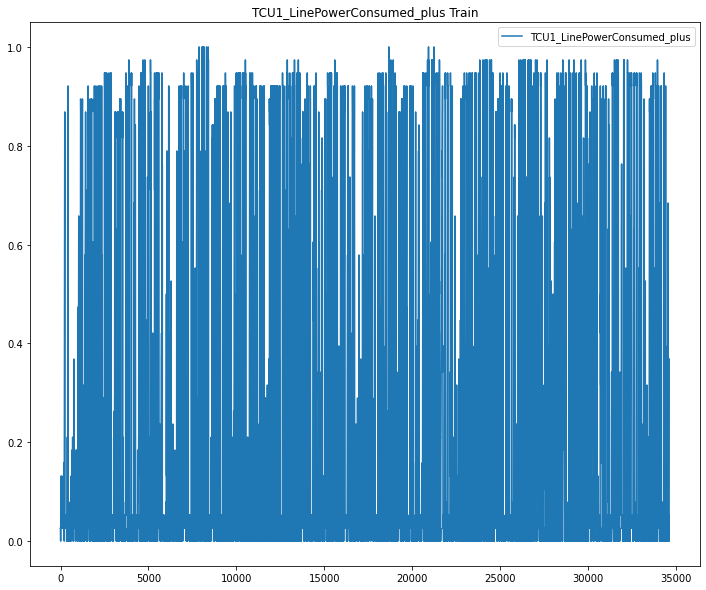

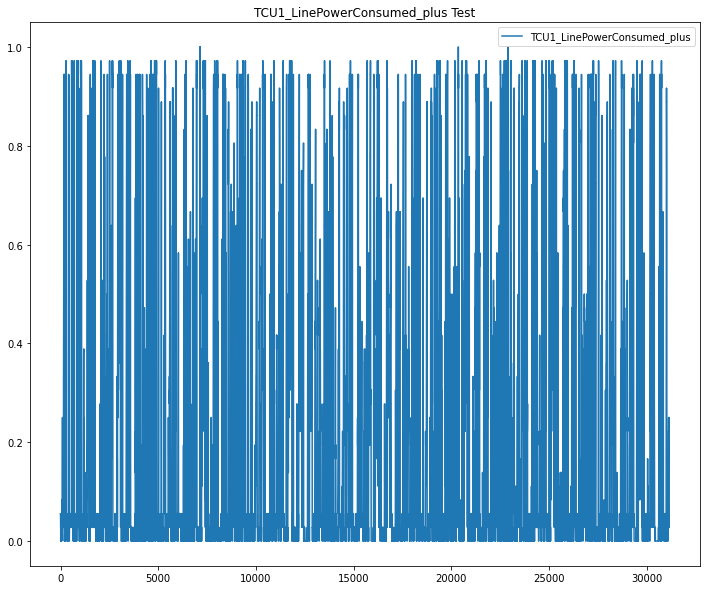

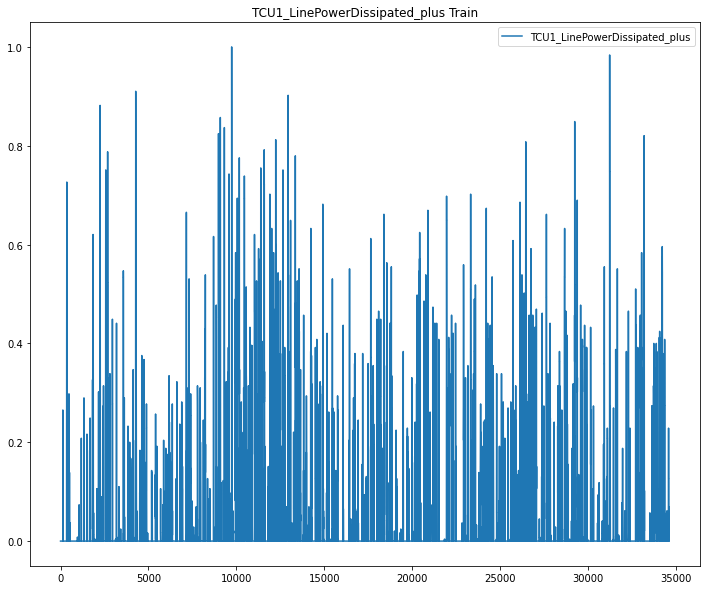

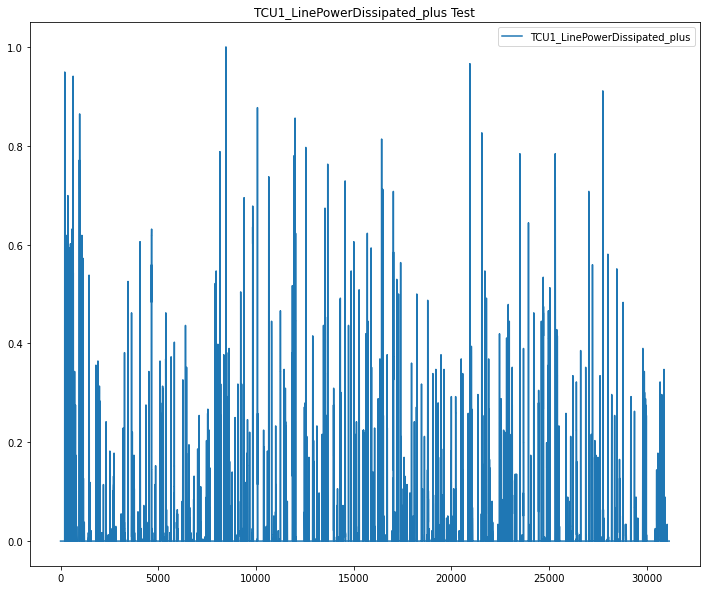

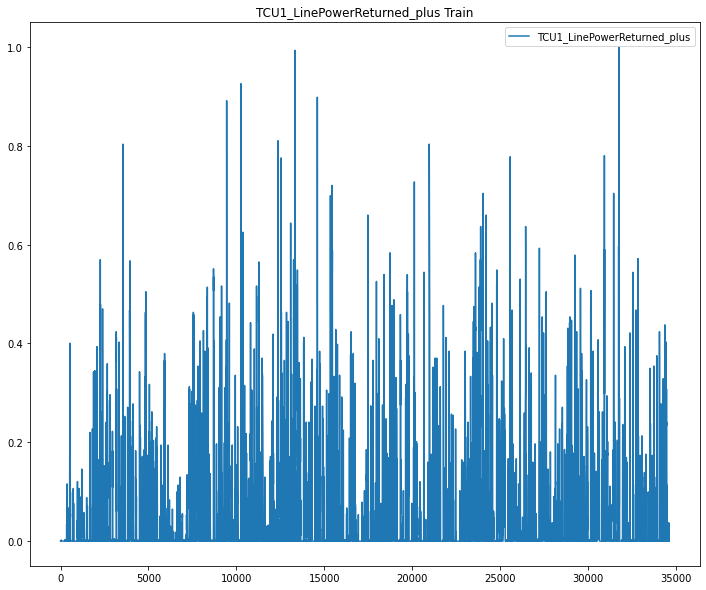

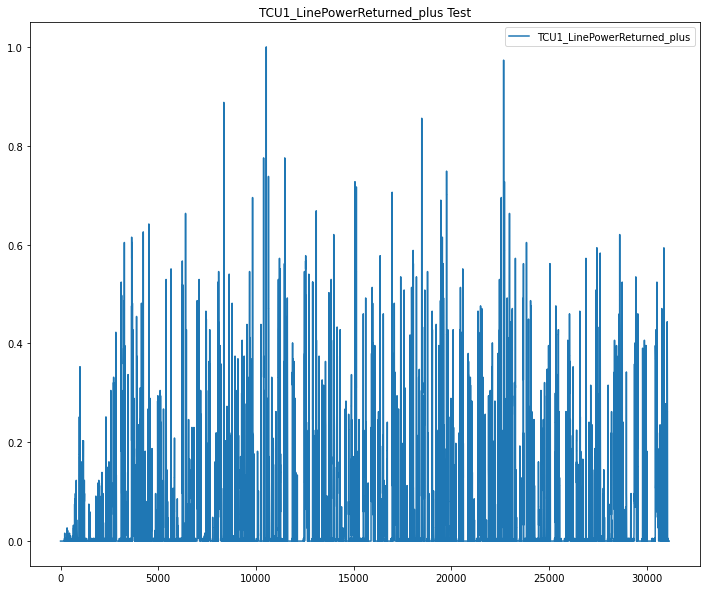

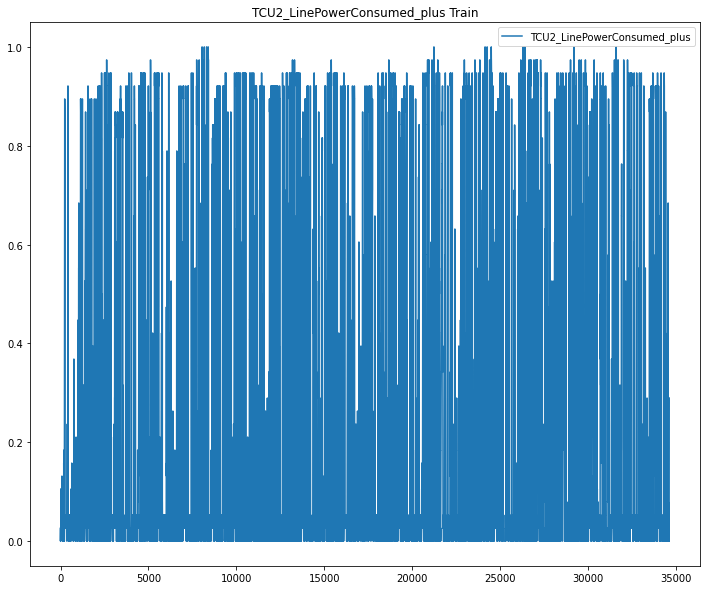

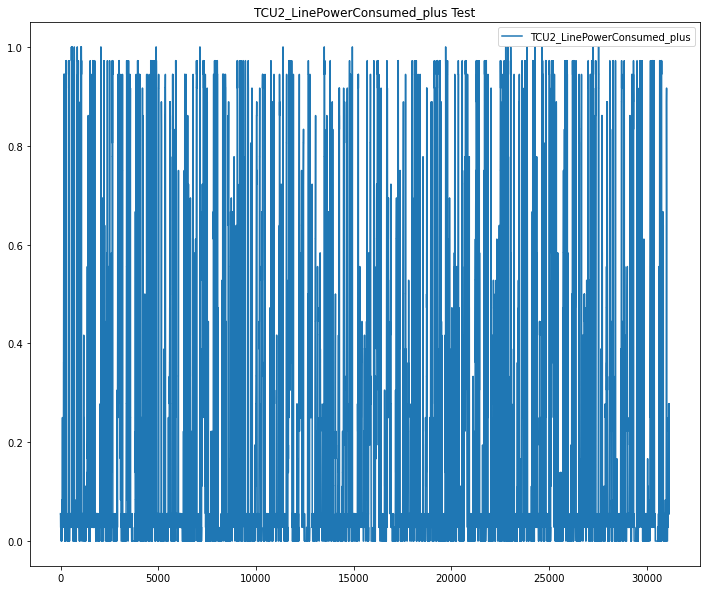

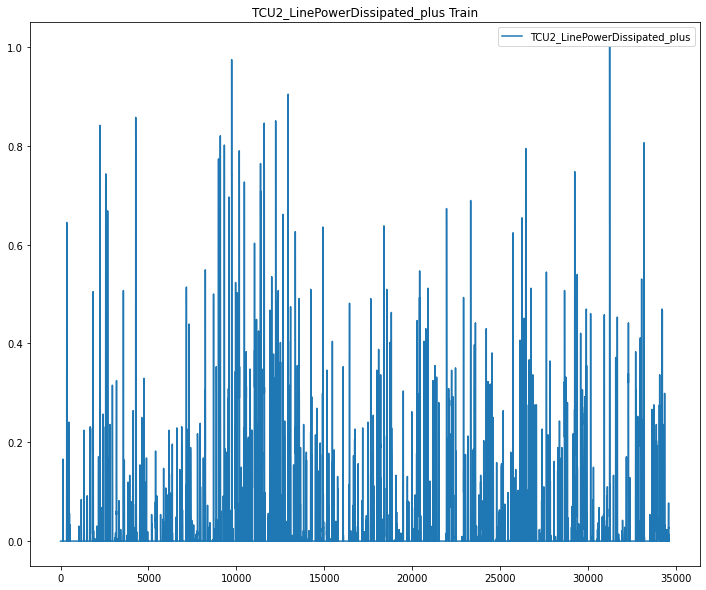

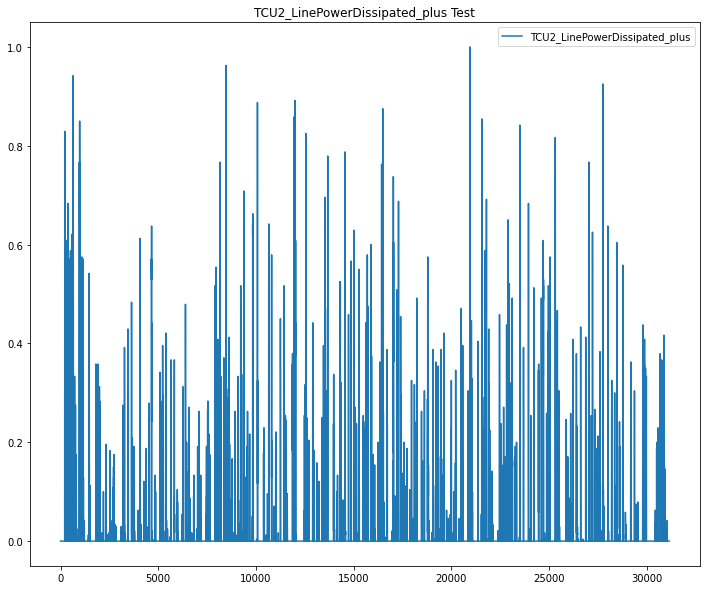

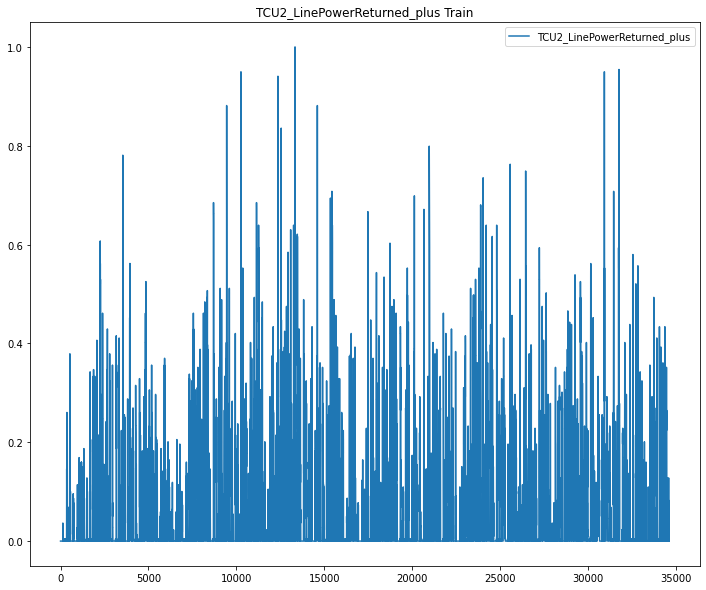

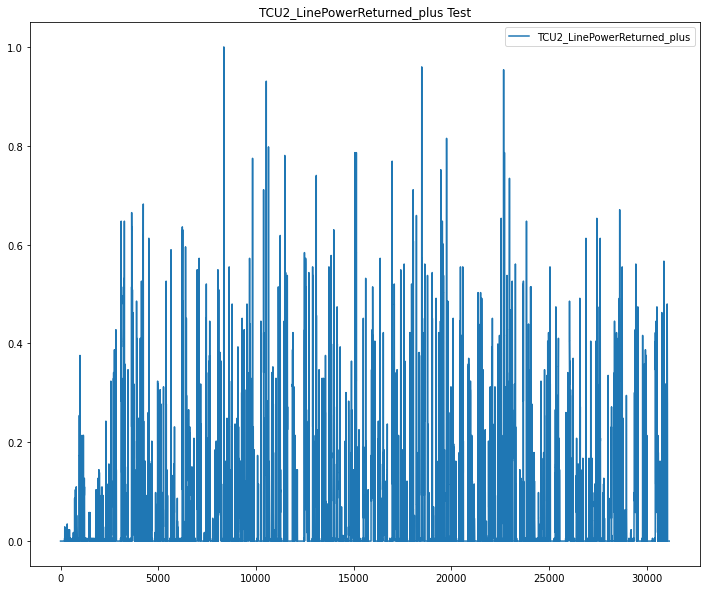

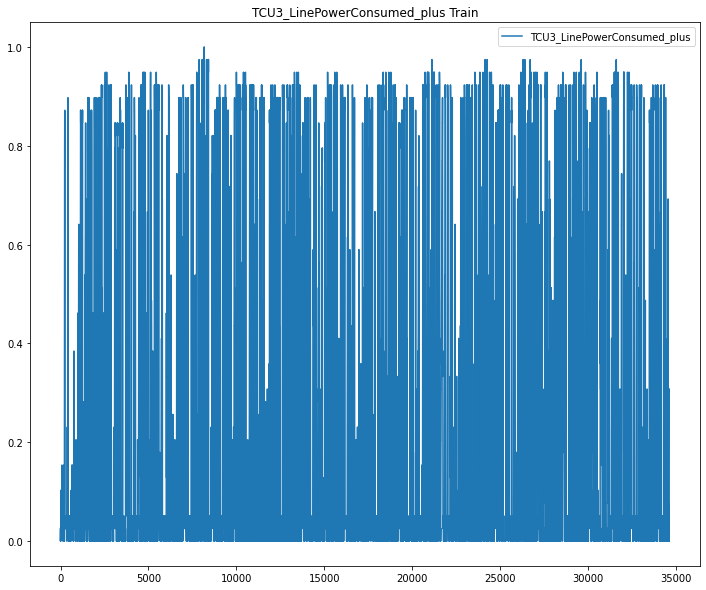

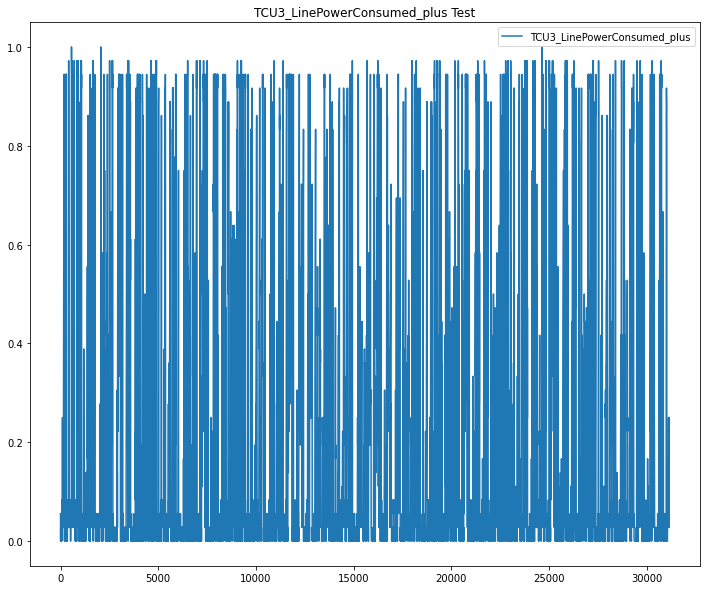

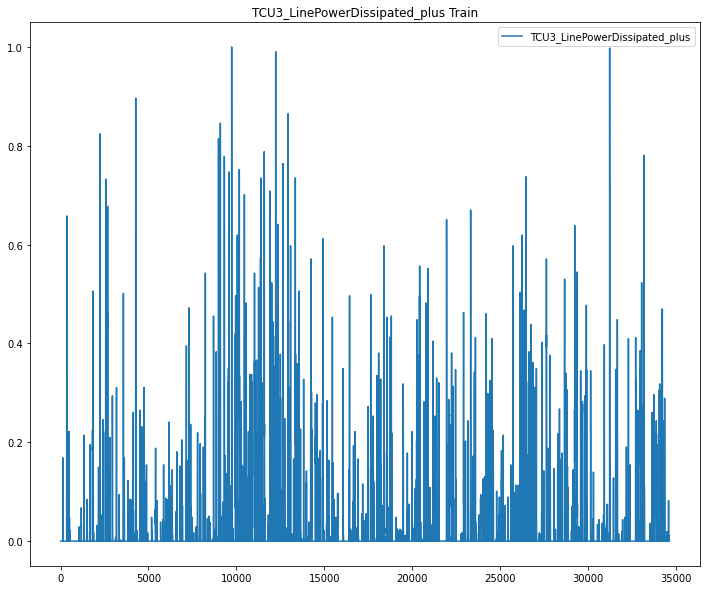

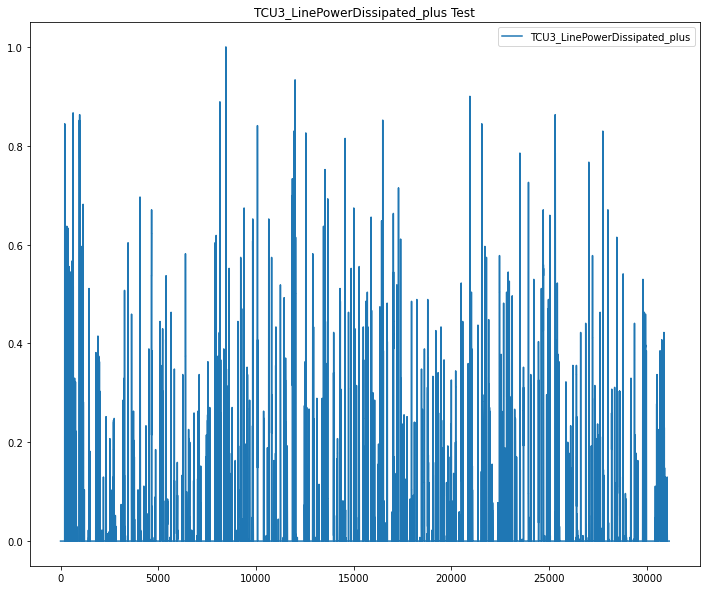

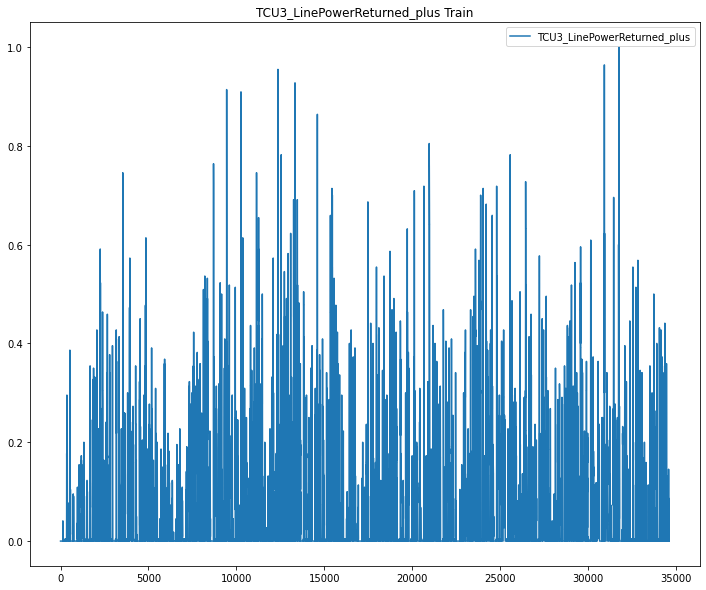

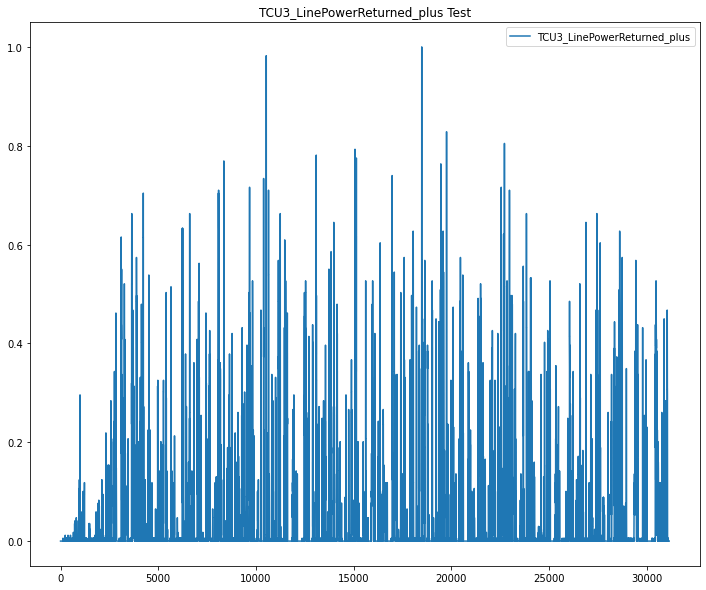

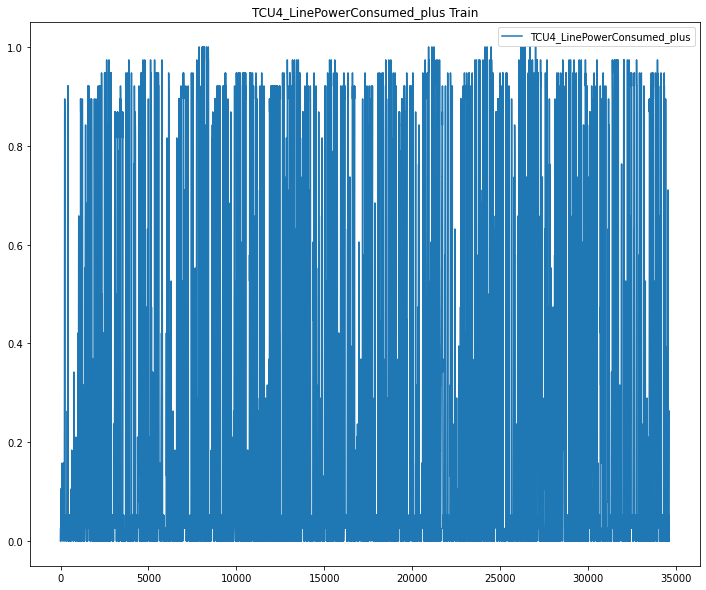

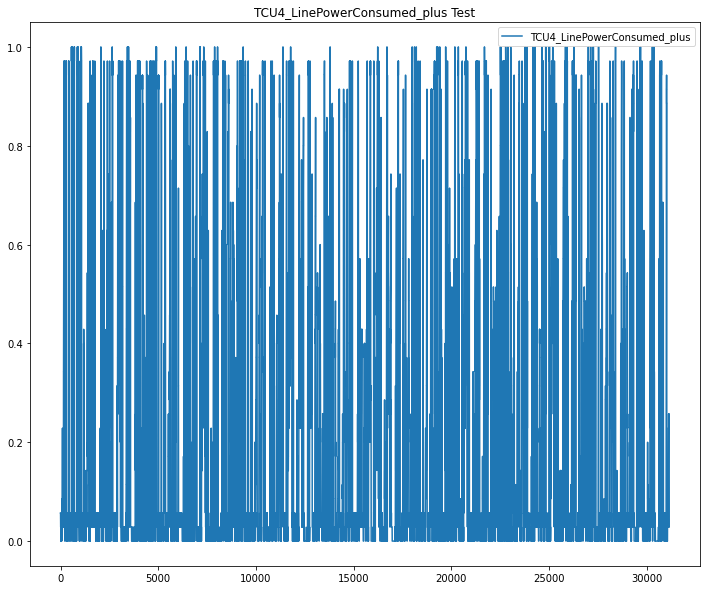

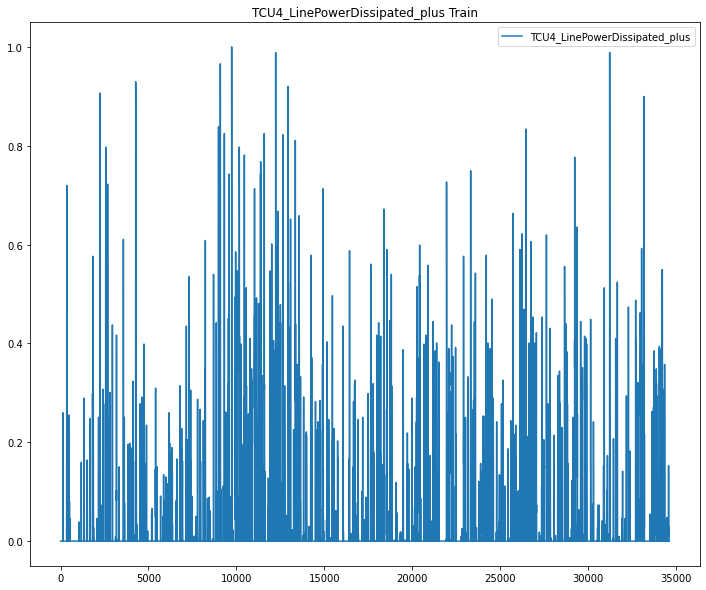

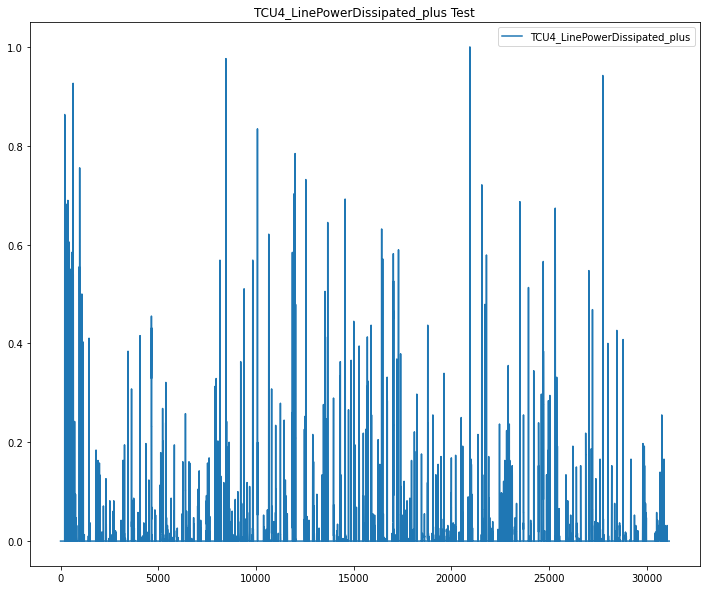

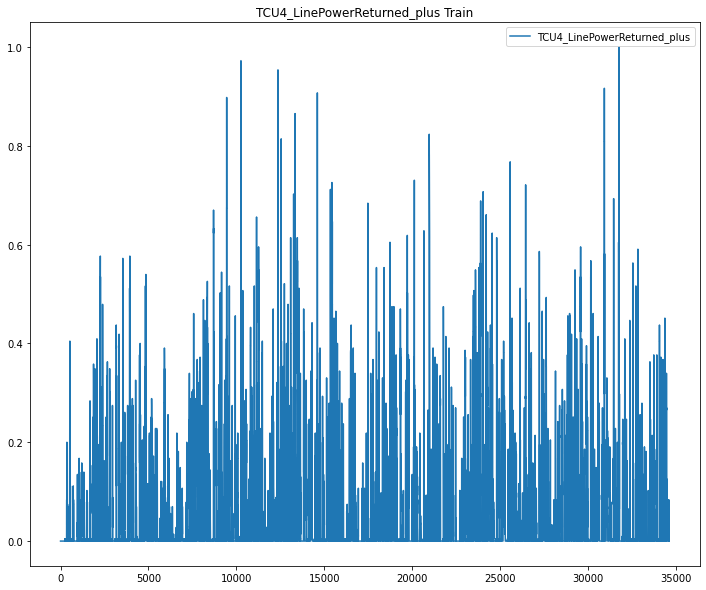

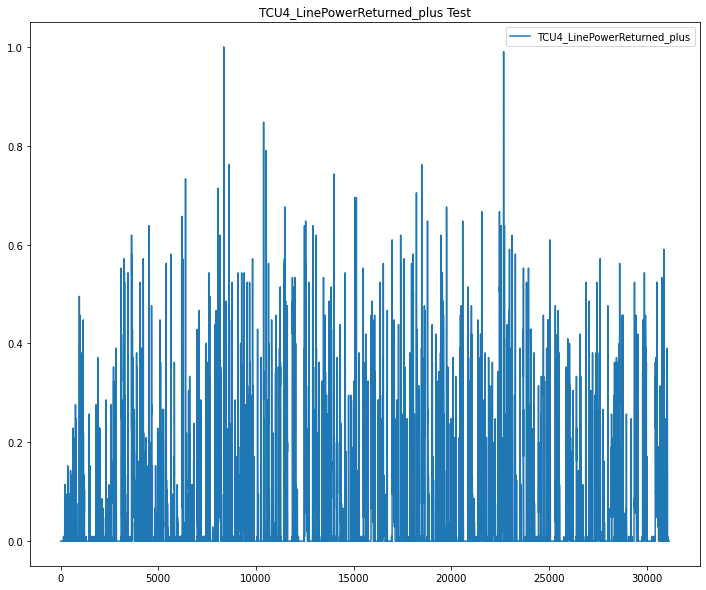

In [ ]:
plot_percent = 0.1
for target in variables_objetivo:
    visualization.plot_one_series(df['train'][target], 
                                  target, 
                                   title=target + ' Train',
                                   plot_percent=plot_percent,
                                   normalize = True)
    
    if 'val' in df:
        visualization.plot_one_series(df['val'][target], 
                                      target, 
                                       title=target + ' Val',
                                       plot_percent=plot_percent,
                                       normalize = True)

    visualization.plot_one_series(df['test'][target], 
                                  target, 
                                   title=target + ' Test',
                                   plot_percent=plot_percent,
                                   normalize = True)

# Partimos datasets

In [ ]:
print (variables_objetivo)
print (df['train'].columns)
print (len(df['train'].columns))

['TCU1_LinePowerConsumed_plus', 'TCU1_LinePowerDissipated_plus', 'TCU1_LinePowerReturned_plus', 'TCU2_LinePowerConsumed_plus', 'TCU2_LinePowerDissipated_plus', 'TCU2_LinePowerReturned_plus', 'TCU3_LinePowerConsumed_plus', 'TCU3_LinePowerDissipated_plus', 'TCU3_LinePowerReturned_plus', 'TCU4_LinePowerConsumed_plus', 'TCU4_LinePowerDissipated_plus', 'TCU4_LinePowerReturned_plus']
Index(['ut', 'TCU1_LinePowerConsumed', 'TCU1_LinePowerDissipated',
       'TCU1_LinePowerReturned', 'TCU2_LinePowerConsumed',
       'TCU2_LinePowerDissipated', 'TCU2_LinePowerReturned',
       'TCU3_LinePowerConsumed', 'TCU3_LinePowerDissipated',
       'TCU3_LinePowerReturned',
       ...
       'TCU1_LinePowerReturned_plus', 'TCU2_LinePowerConsumed_plus',
       'TCU2_LinePowerDissipated_plus', 'TCU2_LinePowerReturned_plus',
       'TCU3_LinePowerConsumed_plus', 'TCU3_LinePowerDissipated_plus',
       'TCU3_LinePowerReturned_plus', 'TCU4_LinePowerConsumed_plus',
       'TCU4_LinePowerDissipated_plus', 'TCU4_L

In [ ]:
import os
def create_filename_template(path,params,target, kfold, val_loss=False):
    filename = ['model']
    if val_loss:
        filename += ['VL{}']
    filename += ['T'+target]
    filename += ['L'+"_".join([str(l) for l in params['layers']])]
    filename += ['D'+str(params['dropout'])]
    filename += ['BN'+str(params['batch_normalization'])]
    filename += ['LR'+str(params['lr'])]
    filename += ['DCY'+str(params['decay'])]
    filename += ['BS'+str(params['batch_size'])]
    filename += ['BS'+str(params['batch_size'])]
    filename += ['I'+str(kfold)]
    filename = "-".join(filename)
    filename = os.path.join(path, filename)
    return filename

def create_params_dict(layers, dropout, batch_normalization, lr, batch_size, epochs,func_act, func_regress):
    return {'layers':layers, 
            'dropout':dropout, 
            'batch_normalization': batch_normalization,
            'lr':lr,
            'decay': lr/epochs,
            'batch_size' :batch_size,
            'func_act':func_act, 
            'func_regress':func_regress}


def create_train_info_dict(path, params,target, kfold, model_conf):
    filename_template = create_filename_template(path, params,target,kfold)
    train_info_dict={}
    train_info_dict['model_conf']=model_conf
    train_info_dict['kfold']=kfold
    train_info_dict['target']=target
    train_info_dict['params']=params
    train_info_dict['model']=filename_template+'.h5'
    train_info_dict['plot_diff']=filename_template+'-diff.jpeg'
    train_info_dict['plot_diff_abs']=filename_template+'-diff-abs.jpeg'
    train_info_dict['plot_pred_real']=filename_template+'-pred_real.jpeg'
    train_info_dict['plot_real_pred']=filename_template+'-real_pred.jpeg'
    train_info_dict['plot_pred']=filename_template+'-pred.jpeg'
    train_info_dict['plot_real']=filename_template+'-_real.jpeg'
    train_info_dict['plot_hist_loss']=filename_template+'-hist_loss.jpeg'
    train_info_dict['train_info']=create_filename_template(path, params,target,kfold,True)+'.pickle'
    if model_conf['model'].get('metrics_name',None) is not None:
        train_info_dict['plot_'+model_conf['model']['metrics_name'][0]]=filename_template+'-'+model_conf['model']['metrics_name'][0] +'.jpeg'
    return train_info_dict
    
def create_plots(history, preds, y_test, target,train_info_dict,model_conf, plot_percent=None ):
    visualization.plot_one_series(preds.flatten(), 
                                  'preds', 
                                   title=target,
                                   plot_percent=plot_percent,
                                   normalize = False,
                                   filename=train_info_dict['plot_pred'])
    visualization.plot_one_series(y_test, 
                                  'y_test', 
                                  title=target,
                                  plot_percent=plot_percent,
                                  normalize = False,
                                  filename=train_info_dict['plot_real'])
    
    visualization.plot_two_series(y_test,
                                  preds.flatten(),
                                  "real", 
                                  "pred",
                                  title=target + 'real-pred',
                                  plot_percent=plot_percent,
                                  normalize = False,
                                  filename=train_info_dict['plot_real_pred'])

    visualization.plot_two_series(preds.flatten(),
                                  y_test,
                                  "pred",
                                  "real", 
                                  title=target+' pred-real',
                                  plot_percent=plot_percent,
                                  normalize = False,
                                  filename=train_info_dict['plot_pred_real'])

    
    visualization.plot_differences(preds.flatten(), 
                                   y_test, 
                                   title=target,
                                   plot_percent=plot_percent,
                                   normalize = False,
                                   filename= train_info_dict['plot_diff'])

    visualization.plot_differences(preds.flatten(), 
                                   y_test, 
                                   title=target + ' Abs', 
                                   absolute=True,
                                   plot_percent=plot_percent,
                                   filename= train_info_dict['plot_diff_abs'])

    

    visualization.plot_history_model(history.history,
                                     ['loss','val_loss'],
                                     f'{target} - {model_conf["model"]["loss_func"]}',
                                     filename= train_info_dict['plot_hist_loss'])

    if model_conf['model'].get('metrics_name',None) is not None:
        plot_history_model(history.history,
                           model_conf['model']['metrics_name'],
                           target,
                           filename=train_info_dict['plot_'+model_conf['model']['metrics_name'][0]])


def quick_analysis(preds, y_test):
    # compute the difference between the *predicted* target and the
    # *actual* target, then compute the percentage difference and
    # the absolute percentage difference


    diff = preds.flatten() - y_test
    percentDiff = (diff / (y_test+0.0000000001)) * 100
    absPercentDiff = np.abs(percentDiff)
    # compute the mean and standard deviation of the absolute percentage
    # difference
    mean = np.mean(absPercentDiff)
    std = np.std(absPercentDiff)

    #print("{} - avg: {}, std: {}".format(target, df['test'][target].mean(),df['test'][target].std()))
    print("{} - avg: {}, std: {}".format(target, np.mean(y_test),np.std(y_test)))
    print("Absolut Percent Difference - mean: {:.2f}%, std: {:.2f}%".format(mean, std))

    

In [ ]:
def scale_targets(targets, train,test, val=None):
    scale_dict={}
    for target in targets:
        scale_dict[target] = train[target].max()
        train[target] /= scale_dict[target]
        test[target] /= scale_dict[target]
        if val is not None:
            val[target] /= scale_dict[target]
    return scale_dict,train,test,val
    

In [ ]:
# Calculamos que columnas tienen valores continuos
continuous_list = models.continous_column_detector(df['train'].drop(conf_dict['ignore_columns']+variables_objetivo+variables_objetivo_current,axis=1))


# Reescalamos los valores continuos entre 0 y 1
df['train'],df['test'],_=models.scaling_attributes(continuous_list, df['train'],df['test'])                

scale_dict,df['train'],df['test'], _ =scale_targets(variables_objetivo+variables_objetivo_current, df['train'],df['test'])

# Creamos un directorio donde vamos a guardar toda la informacion
utils.create_dir(store_model_path)                



 [Tue, 20 Apr 2021 20:09:50] ERROR [utils.py.create_dir:15] Creation of the directory /home/maguelo/Workspace/cafcoding/notebook/models/ failed


In [ ]:
continuous_list

['TCU1_DCBusVoltage',
 'TCU2_DCBusVoltage',
 'TCU3_DCBusVoltage',
 'TCU4_DCBusVoltage',
 'TCU1_CatenaryVoltage',
 'TCU2_CatenaryVoltage',
 'TCU3_CatenaryVoltage',
 'TCU4_CatenaryVoltage',
 'ER_TotKm',
 'PLC_TRACTION_BRAKE_COMMAND',
 'PLC_Speed',
 'PLC_TempExt',
 'EPAC1_WSP_Acting',
 'EPAC2_WSP_Acting',
 'PLC_MassM1',
 'PLC_MassM2',
 'PLC_MassR1',
 'PLC_MassR2',
 'PLC_VLinea_M1',
 'PLC_VLinea_M2',
 'ER_EUIdSenal1',
 'ER_EUIdSenal2',
 'ER_EUIdSenal3',
 'ER_EUIdSenal4',
 'ER_EUIdSenal5',
 'ER_EUIdSenal6',
 'ER_EUIdSenal7',
 'ER_EUIdSenal8',
 'PLC_MASTER_CONTROLLER_POS',
 'SI_GPS_Speed',
 'hri',
 'altitude',
 'slope',
 'distance',
 'percent_slope',
 'TCU1_Axle1Speed_abs',
 'TCU1_Axle2Speed_abs',
 'TCU1_ElecEffApp_abs',
 'TCU2_Axle1Speed_abs',
 'TCU2_Axle2Speed_abs',
 'TCU2_ElecEffApp_abs',
 'TCU3_Axle1Speed_abs',
 'TCU3_Axle2Speed_abs',
 'TCU3_ElecEffApp_abs',
 'TCU4_Axle1Speed_abs',
 'TCU4_Axle2Speed_abs',
 'TCU4_ElecEffApp_abs',
 'TCU1_LinePowerConsumed_1',
 'TCU1_LinePowerDissipated_1',

In [ ]:
discard_columns = ['ER_EUIdSenal1',
                   'ER_EUIdSenal2',
                   'ER_EUIdSenal3','ER_EUIdSenal4','ER_EUIdSenal5','ER_EUIdSenal6','ER_EUIdSenal7','ER_EUIdSenal8',
                   'EPAC1_WSP_Acting_1','EPAC1_WSP_Acting_dif','EPAC2_WSP_Acting_1','EPAC2_WSP_Acting_dif',
                    'PLC_Speed_1',
                    'PLC_Speed_dif',
                    'PLC_TRACTION_BRAKE_COMMAND_1',
                    'PLC_TRACTION_BRAKE_COMMAND_dif',
                    'TCU1_Axle1Speed_abs_1',
                    'TCU1_Axle1Speed_abs_dif',
                    'TCU1_Axle2Speed_abs_1',
                    'TCU1_Axle2Speed_abs_dif',
                    'TCU1_DCBusVoltage_1',
                    'TCU1_DCBusVoltage_dif',
                    'TCU1_ElecEffApp_abs_1',
                    'TCU1_ElecEffApp_abs_dif',
                    'TCU1_LinePowerConsumed_1',
                    'TCU1_LinePowerConsumed_dif',
                    'TCU1_LinePowerDissipated_1',
                    'TCU1_LinePowerDissipated_dif',
                    'TCU1_LinePowerReturned_1',
                    'TCU1_LinePowerReturned_dif',
                    'TCU2_Axle1Speed_abs_1',
                    'TCU2_Axle1Speed_abs_dif',
                    'TCU2_Axle2Speed_abs_1',
                    'TCU2_Axle2Speed_abs_dif',
                    'TCU2_DCBusVoltage_1',
                    'TCU2_DCBusVoltage_dif',
                    'TCU2_ElecEffApp_abs_1',
                    'TCU2_ElecEffApp_abs_dif',
                    'TCU2_LinePowerConsumed_1',
                    'TCU2_LinePowerConsumed_dif',
                    'TCU2_LinePowerDissipated_1',
                    'TCU2_LinePowerDissipated_dif',
                    'TCU2_LinePowerReturned_1',
                    'TCU2_LinePowerReturned_dif',
                    'TCU3_Axle1Speed_abs_1',
                    'TCU3_Axle1Speed_abs_dif',
                    'TCU3_Axle2Speed_abs_1',
                    'TCU3_Axle2Speed_abs_dif',
                    'TCU3_DCBusVoltage_1',
                    'TCU3_DCBusVoltage_dif',
                    'TCU3_ElecEffApp_abs_1',
                    'TCU3_ElecEffApp_abs_dif',
                    'TCU3_LinePowerConsumed_1',
                    'TCU3_LinePowerConsumed_dif',
                    'TCU3_LinePowerDissipated_1',
                    'TCU3_LinePowerDissipated_dif',
                    'TCU3_LinePowerReturned_1',
                    'TCU3_LinePowerReturned_dif',
                    'TCU4_Axle1Speed_abs_1',
                    'TCU4_Axle1Speed_abs_dif',
                    'TCU4_Axle2Speed_abs_1',
                    'TCU4_Axle2Speed_abs_dif',
                    'TCU4_DCBusVoltage_1',
                    'TCU4_DCBusVoltage_dif',
                    'TCU4_ElecEffApp_abs_1',
                    'TCU4_ElecEffApp_abs_dif',
                    'TCU4_LinePowerConsumed_1',
                    'TCU4_LinePowerConsumed_dif',
                    'TCU4_LinePowerDissipated_1',
                    'TCU4_LinePowerDissipated_dif',
                    'TCU4_LinePowerReturned_1',
                    'TCU4_LinePowerReturned_dif',
                    'slope',
                    'ER_TotKm','PLC_MASTER_CONTROLLER_POS','SI_GPS_Speed','distance','altitude',
                    'lat_wind',
                    'AutoEficient','ManeuverMode','ImpSpeedMode','ManEficient',
                  'TCU1_LinePowerConsumed',

'TCU1_LinePowerDissipated',

'TCU1_LinePowerReturned',
'TCU2_LinePowerConsumed',

'TCU2_LinePowerDissipated',

'TCU2_LinePowerReturned',
'TCU3_LinePowerConsumed',

'TCU3_LinePowerDissipated',

'TCU3_LinePowerReturned',
'TCU4_LinePowerConsumed',

'TCU4_LinePowerDissipated',

'TCU4_LinePowerReturned',]

# Temporal
# 'Coupled', 'EPAC1_WSP_Acting', 'EPAC2_WSP_Acting', 'Manual', 'PLC_DS_CAB1', 'PLC_DS_CAB2', 'PLC_MassM1', 
# 'PLC_MassM2', 'PLC_MassR1', 'PLC_MassR2', 'PLC_Speed', 'PLC_TRACTION_BRAKE_COMMAND', 'PLC_TempExt', 'PLC_VLinea_M1', 
# 'PLC_VLinea_M2', 'TCU1_CatenaryVoltage', 'TCU1_DCBusVoltage', 
# 'TCU1_ElecEffApp_abs', 'TCU2_CatenaryVoltage', 'TCU2_DCBusVoltage', 'TCU2_ElecEffApp_abs','TCU3_CatenaryVoltage',
# 'TCU3_DCBusVoltage', 'TCU3_ElecEffApp_abs', 
# 'TCU4_CatenaryVoltage', 'TCU4_DCBusVoltage', 'TCU4_ElecEffApp_abs', 'fr_wind', 'hri', 'percent_slope', 
# 'plc_mcp_braking_effort_requested', 'plc_mcp_coasting_requested', 'plc_mcp_error_unknown_requested',
# 'plc_mcp_propulsion_effort_requested', 'plc_mcp_urgency_brake_requested', 'precipitacion_pluviometro_acu']


features=sorted(df['train'].columns)
for col in features:
    if col in discard_columns:
        continue
    print (col)
    
#'TCU1_Axle1Speed_abs', 'TCU1_Axle2Speed_abs''TCU2_Axle1Speed_abs', 'TCU2_Axle2Speed_abs' 'TCU3_Axle1Speed_abs', 'TCU3_Axle2Speed_abs', 'TCU4_Axle1Speed_abs', 'TCU4_Axle2Speed_abs', 

TCU1_Axle1Speed_abs
TCU1_Axle2Speed_abs
TCU1_LinePowerConsumed_plus
TCU1_LinePowerDissipated_plus
TCU1_LinePowerReturned_plus
TCU2_Axle1Speed_abs
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed_plus
TCU2_LinePowerDissipated_plus
TCU2_LinePowerReturned_plus
TCU3_Axle1Speed_abs
TCU3_Axle2Speed_abs
TCU3_LinePowerConsumed_plus
TCU3_LinePowerDissipated_plus
TCU3_LinePowerReturned_plus
TCU4_Axle1Speed_abs
TCU4_Axle2Speed_abs
TCU4_LinePowerConsumed_plus
TCU4_LinePowerDissipated_plus
TCU4_LinePowerReturned_plus
date_day
ts_date
ut


In [ ]:
import cafcoding.constants as constants
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop

from keras import regularizers


from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
def create_model(input_dim, layers, dropout=None, batch_normalization = False, regress=False, func_act='relu', func_regress='linear'):
    # define our MLP network
    logger.info("Create model")
    logger.debug(f'input_dim: {input_dim}')
    logger.debug(f'layers: {layers}')
    logger.debug(f'dropout: {dropout}')
    logger.debug(f'batch_normalization: {batch_normalization}')
    logger.debug(f'regress: {regress}')

    dropout = 0.0 if dropout is None else dropout

    model = Sequential()
    model.add(Dense(layers[0], 
                    input_dim=input_dim, activation=func_act,
                    kernel_initializer='random_normal',
                    bias_initializer='zeros'))
    for layer in layers[1:]:
        if dropout:
            model.add(Dropout(dropout))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dense(layer, activation=func_act))

    if regress:
        model.add(Dense(1, activation=func_regress))
    else:
        model.add(Dense(1, activation="sigmoid"))
    return model

def create_model_functional(input_dim, layers, dropout=None, batch_normalization = False, regress=False, func_act='relu', func_regress='linear'):
    # define our MLP network
    logger.info("Create model")
    logger.debug(f'input_dim: {input_dim}')
    logger.debug(f'layers: {layers}')
    logger.debug(f'dropout: {dropout}')
    logger.debug(f'batch_normalization: {batch_normalization}')
    logger.debug(f'regress: {regress}')
    logger.debug(f'func_act: {func_act}')
    logger.debug(f'func_regress: {func_regress}')

    dropout = 0.0 if dropout is None else dropout

    x = Input(shape=(input_dim,))
    hide = Dense(layers[0], activation=func_act)(x)
    for layer in layers[1:]:
        if dropout:
            hide=Dropout(dropout)(hide)
        if batch_normalization:
            hide=BatchNormalization()(hide)
        hide=Dense(layer, activation=func_act)(hide)

    if regress:
        y= Dense(1, activation=func_regress)(hide)
    else:
        y =Dense(1, activation="sigmoid")(hide)
        
    model = Model(x, y)
    return model


def train_model_dl(train_data, val_data, params, model_conf, filename = None):
    logger.debug('Train model - params: {}'.format(str(params)))
    logger.debug('Train model - model_conf: {}'.format(str(model_conf)))
                 
    X_train, y_train = train_data
    X_val, y_val = val_data
    model = create_model_functional(X_train.shape[1], 
                         params['layers'], 
                         dropout=params.get('dropout',0.0), 
                         batch_normalization=params.get('batch_normalization',False),
                         regress=True,
                         func_act=params.get('func_act', 'relu'),
                         func_regress=params.get('func_regress', 'linear'))
    model.summary()
    
    callback_list = []

    if  model_conf.get('early_stopping', None) is not None:
    # patient early stopping
        early_stopping = EarlyStopping(monitor=model_conf['early_stopping'].get('monitor','val_loss'), mode='min', verbose=model_conf['early_stopping'].get('verbose',1), patience=model_conf['early_stopping'].get('monitor_patience',15))
        callback_list.append(early_stopping)
    
    if filename is not None:
        logger.info(f'Checkpoint model in {filename}')
        model_checkpoint = ModelCheckpoint(filename, 
                                           monitor=model_conf['model_checkpoint'].get('monitor','val_loss'), 
                                           mode='min', 
                                           verbose=model_conf['model_checkpoint'].get('verbose',1), 
                                           save_best_only=model_conf['model_checkpoint'].get('save_best',True))
        
        callback_list.append(model_checkpoint)
    
    # compile the model using mean absolute percentage error as our loss,
    # implying that we seek to minimize the absolute percentage difference
    # between our target *predictions* and the *actual prices*
#     opt = RMSprop(lr=params["lr"], rho=0.9, epsilon=None, decay=params["decay"])
    opt = Adam(lr=params["lr"], decay=params["decay"])
    model.compile(loss=model_conf['model'].get('loss_func',"mean_absolute_percentage_error"), 
                  optimizer=opt,
                  metrics=model_conf['model'].get('metrics',None))

    # train the model
    logger.info("[INFO] training model...")
    
    history =model.fit(x=X_train, y=y_train,
            callbacks=callback_list,
            validation_data=(X_val, y_val),
            epochs=model_conf.get('epochs',200), 
            batch_size=params.get("batch_size",64),
            verbose= model_conf['model'].get('verbose',1))

    return history, early_stopping.best, model


1440
TCU1_LinePowerConsumed_plus
0/1440
Fold : 0/3
{'layers': (64, 32, 16), 'dropout': 0.5, 'batch_normalization': True, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'tanh'}
 [Tue, 20 Apr 2021 23:14:05] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (64, 32, 16), 'dropout': 0.5, 'batch_normalization': True, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'tanh'}
 [Tue, 20 Apr 2021 23:14:05] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:14:05] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [Tue, 20 Apr 2021 23:14:05] D

Epoch 61/500
1459/1459 - 1s - loss: 2531226.0000 - val_loss: 1035881.4375
Epoch 62/500
1459/1459 - 1s - loss: 2445060.7500 - val_loss: 1034696.3750
Epoch 63/500
1459/1459 - 1s - loss: 2405294.0000 - val_loss: 1069898.6250
Epoch 64/500
1459/1459 - 1s - loss: 2279925.7500 - val_loss: 895248.8125
Epoch 65/500
1459/1459 - 1s - loss: 2219555.0000 - val_loss: 941023.0000
Epoch 66/500
1459/1459 - 1s - loss: 2207591.2500 - val_loss: 1083596.1250
Epoch 67/500
1459/1459 - 1s - loss: 2130896.2500 - val_loss: 868568.1875
Epoch 68/500
1459/1459 - 1s - loss: 2038487.0000 - val_loss: 747933.6250
Epoch 69/500
1459/1459 - 1s - loss: 2038092.0000 - val_loss: 862209.5000
Epoch 70/500
1459/1459 - 1s - loss: 1926234.7500 - val_loss: 699265.0625
Epoch 71/500
1459/1459 - 1s - loss: 1870361.6250 - val_loss: 718651.4375
Epoch 72/500
1459/1459 - 1s - loss: 1790997.5000 - val_loss: 778000.6250
Epoch 73/500
1459/1459 - 1s - loss: 1761593.3750 - val_loss: 739619.8125
Epoch 74/500
1459/1459 - 1s - loss: 1701093.625

Epoch 175/500
1459/1459 - 1s - loss: 2835.9341 - val_loss: 1906.4603
Epoch 176/500
1459/1459 - 1s - loss: 3157.1670 - val_loss: 8334.4629
Epoch 177/500
1459/1459 - 1s - loss: 3082.5537 - val_loss: 7118.5161
Epoch 178/500
1459/1459 - 1s - loss: 3419.8306 - val_loss: 6714.5171
Epoch 179/500
1459/1459 - 1s - loss: 3240.3589 - val_loss: 1612.9647
Epoch 180/500
1459/1459 - 1s - loss: 3142.0007 - val_loss: 1691.6390
Epoch 181/500
1459/1459 - 1s - loss: 2767.8284 - val_loss: 1052.5070
Epoch 182/500
1459/1459 - 1s - loss: 3167.3174 - val_loss: 305.1694
Epoch 183/500
1459/1459 - 1s - loss: 3015.4302 - val_loss: 1429.1805
Epoch 184/500
1459/1459 - 1s - loss: 3157.7542 - val_loss: 4324.2993
Epoch 185/500
1459/1459 - 1s - loss: 2914.0239 - val_loss: 1715.1348
Epoch 186/500
1459/1459 - 1s - loss: 3472.4412 - val_loss: 855.7892
Epoch 187/500
1459/1459 - 1s - loss: 2992.9868 - val_loss: 2449.2363
Epoch 188/500
1459/1459 - 1s - loss: 3508.2012 - val_loss: 114.1681
Epoch 189/500
1459/1459 - 1s - loss: 

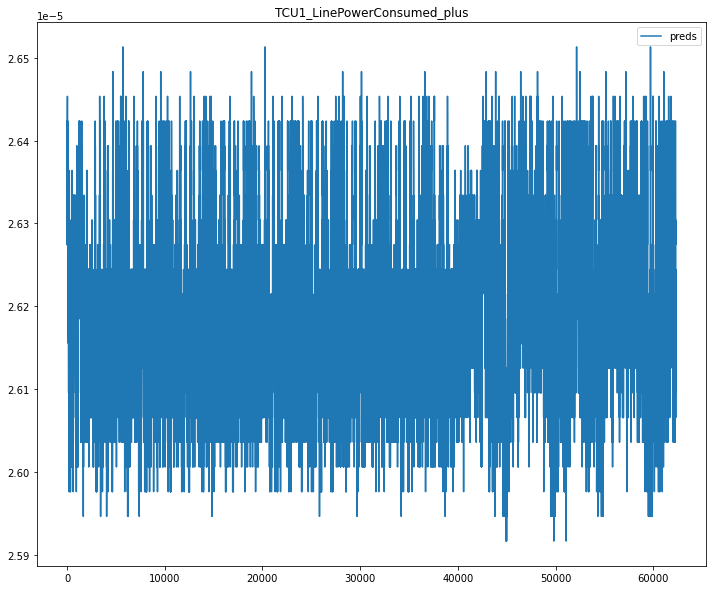

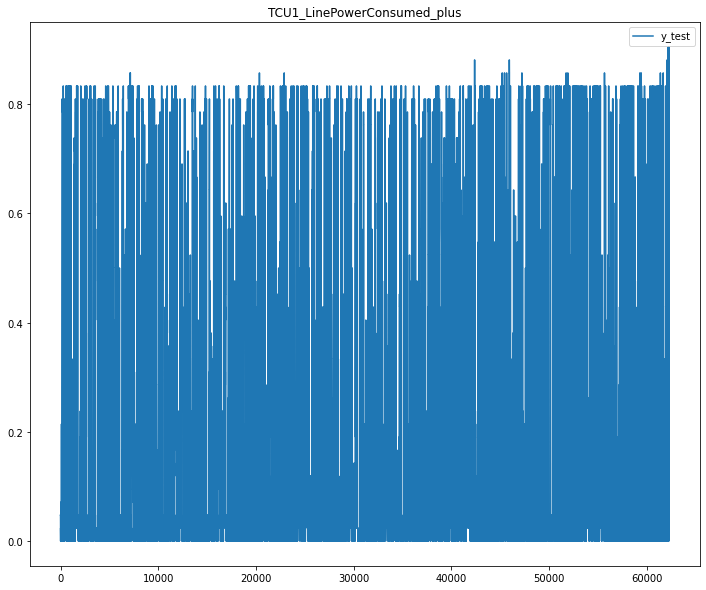

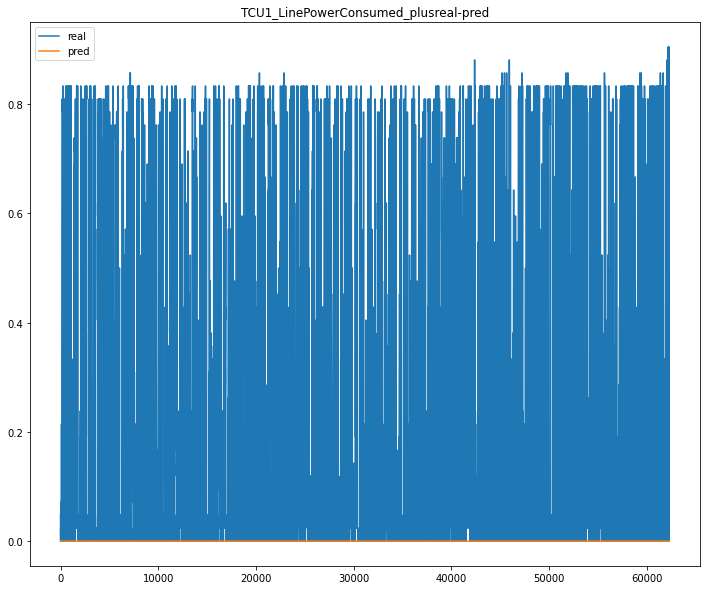

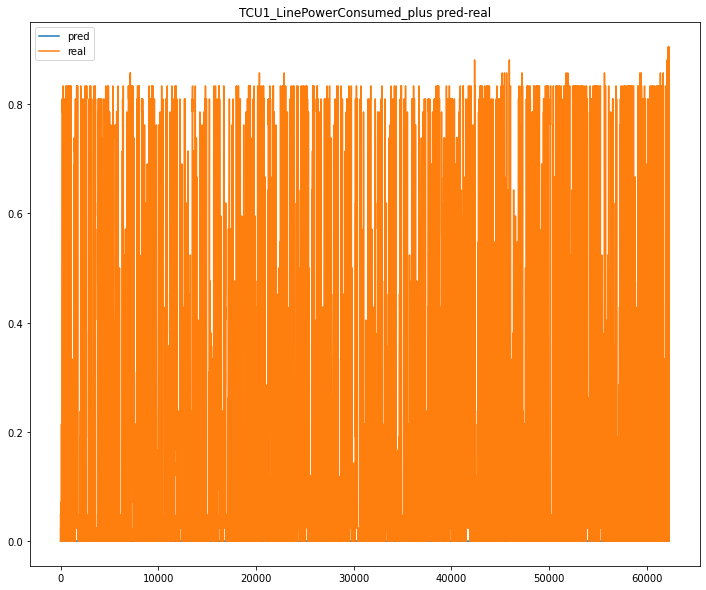

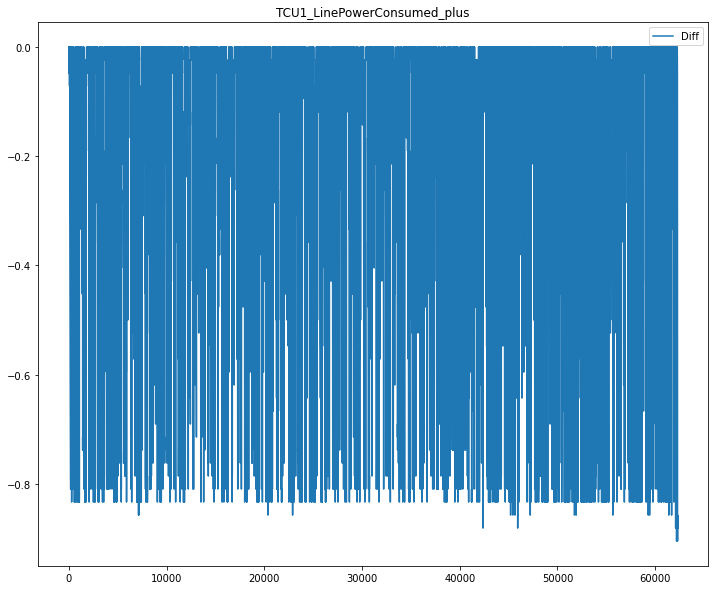

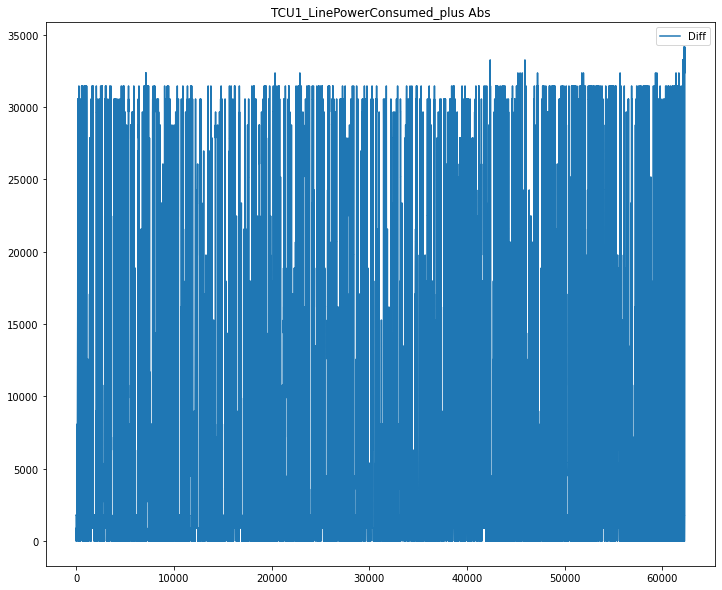

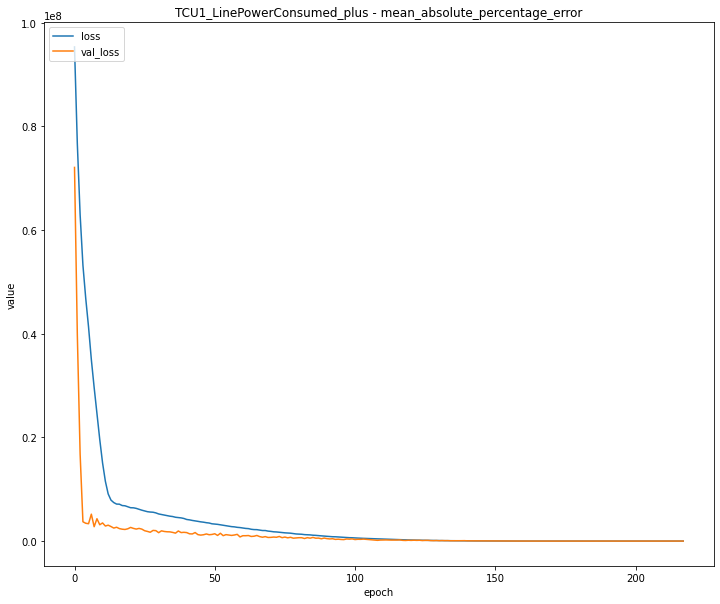

Fold : 1/3
Fold : 2/3
1/1440
Fold : 0/3
{'layers': (64, 32, 16), 'dropout': None, 'batch_normalization': True, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'tanh'}
 [Tue, 20 Apr 2021 23:18:51] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (64, 32, 16), 'dropout': None, 'batch_normalization': True, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'tanh'}
 [Tue, 20 Apr 2021 23:18:51] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:18:51] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [Tue, 20 Apr 2021 23:18:51] DEBUG [<ip

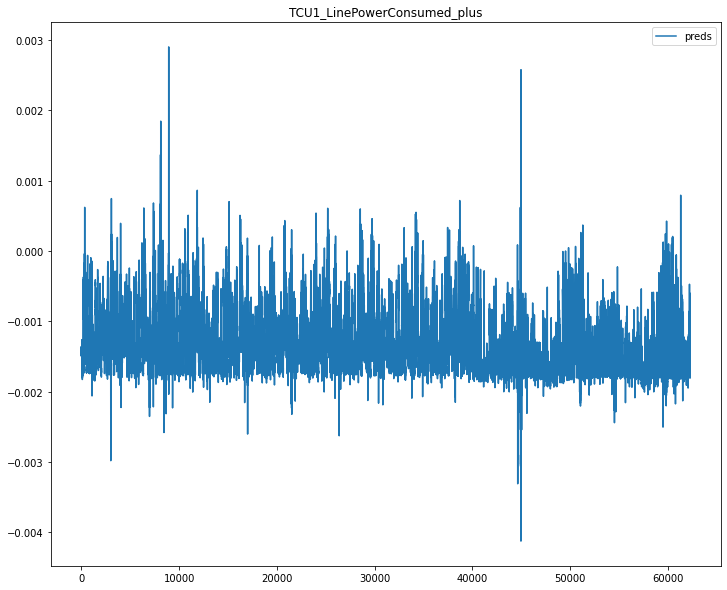

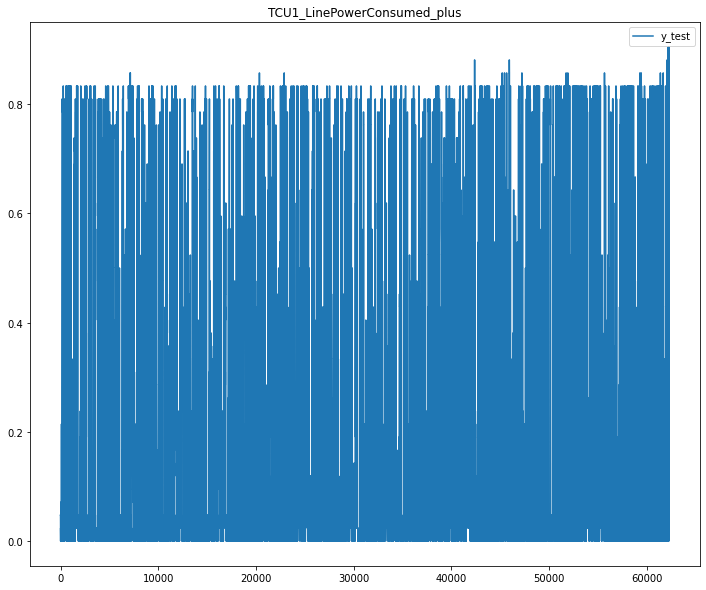

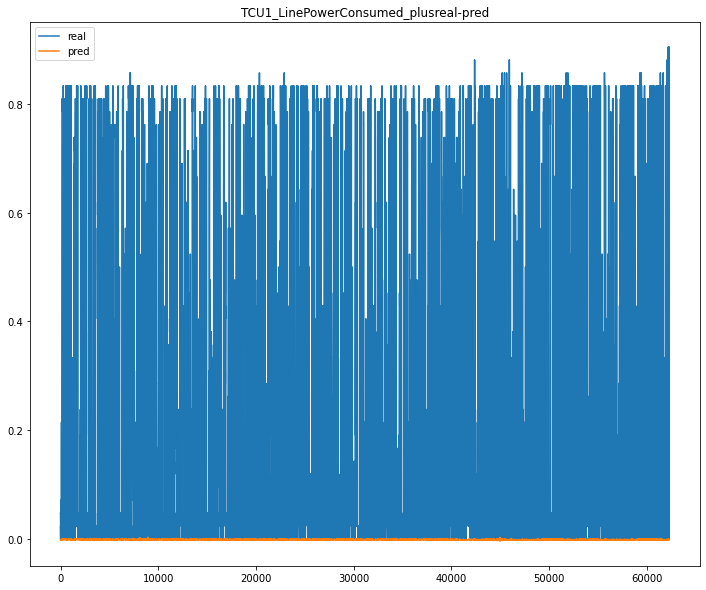

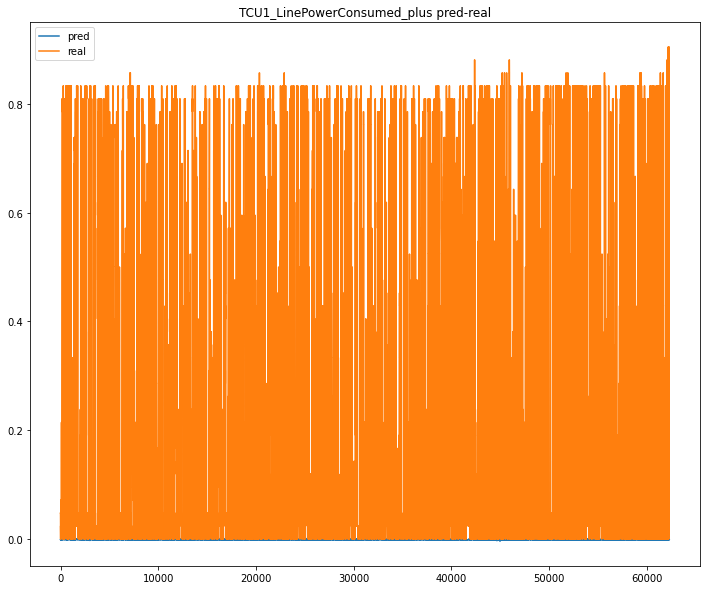

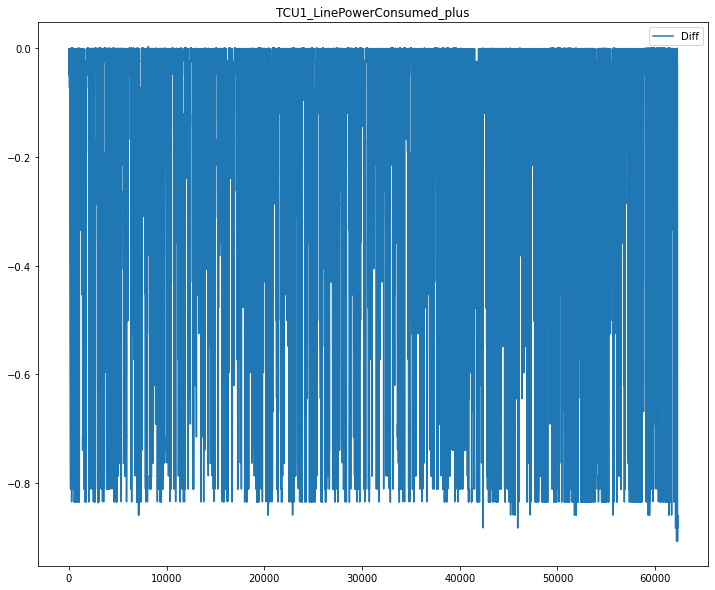

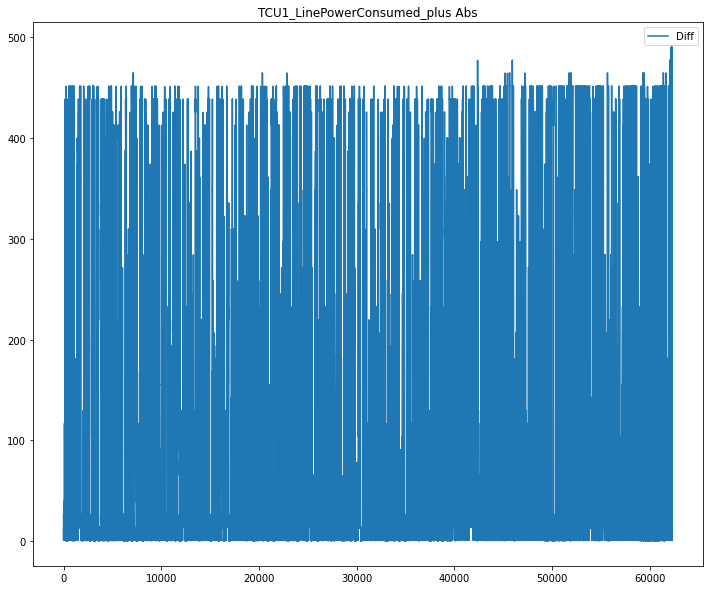

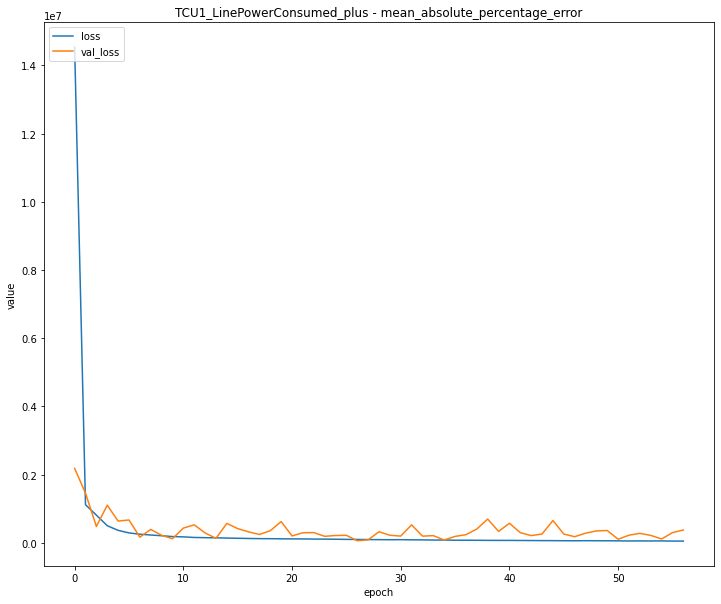

Fold : 1/3
Fold : 2/3
2/1440
Fold : 0/3
{'layers': (8, 4), 'dropout': None, 'batch_normalization': False, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'tanh', 'func_regress': 'linear'}
 [Tue, 20 Apr 2021 23:20:07] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (8, 4), 'dropout': None, 'batch_normalization': False, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'tanh', 'func_regress': 'linear'}
 [Tue, 20 Apr 2021 23:20:07] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:20:07] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [Tue, 20 Apr 202

Epoch 68/500
1459/1459 - 1s - loss: 10464600.0000 - val_loss: 10167659.0000
Epoch 69/500
1459/1459 - 1s - loss: 10363998.0000 - val_loss: 10068226.0000
Epoch 70/500
1459/1459 - 1s - loss: 10267430.0000 - val_loss: 9972087.0000
Epoch 71/500
1459/1459 - 1s - loss: 10172720.0000 - val_loss: 9878596.0000
Epoch 72/500
1459/1459 - 1s - loss: 10081476.0000 - val_loss: 9788482.0000
Epoch 73/500
1459/1459 - 1s - loss: 9992749.0000 - val_loss: 9700984.0000
Epoch 74/500
1459/1459 - 1s - loss: 9906704.0000 - val_loss: 9616264.0000
Epoch 75/500
1459/1459 - 1s - loss: 9823309.0000 - val_loss: 9533809.0000
Epoch 76/500
1459/1459 - 1s - loss: 9741486.0000 - val_loss: 9453150.0000
Epoch 77/500
1459/1459 - 1s - loss: 9662179.0000 - val_loss: 9375439.0000
Epoch 78/500
1459/1459 - 1s - loss: 9584176.0000 - val_loss: 9298620.0000
Epoch 79/500
1459/1459 - 1s - loss: 9508205.0000 - val_loss: 9224384.0000
Epoch 80/500
1459/1459 - 1s - loss: 9433450.0000 - val_loss: 9150898.0000
Epoch 81/500
1459/1459 - 1s - l

Epoch 178/500
1459/1459 - 1s - loss: 4604628.0000 - val_loss: 4433016.0000
Epoch 179/500
1459/1459 - 1s - loss: 4576887.5000 - val_loss: 4406038.5000
Epoch 180/500
1459/1459 - 1s - loss: 4549675.5000 - val_loss: 4380057.5000
Epoch 181/500
1459/1459 - 1s - loss: 4522784.0000 - val_loss: 4353838.0000
Epoch 182/500
1459/1459 - 1s - loss: 4495858.5000 - val_loss: 4328120.0000
Epoch 183/500
1459/1459 - 1s - loss: 4469335.0000 - val_loss: 4302647.0000
Epoch 184/500
1459/1459 - 1s - loss: 4442751.5000 - val_loss: 4276704.5000
Epoch 185/500
1459/1459 - 1s - loss: 4416111.5000 - val_loss: 4251322.5000
Epoch 186/500
1459/1459 - 1s - loss: 4389709.5000 - val_loss: 4225722.0000
Epoch 187/500
1459/1459 - 1s - loss: 4363505.0000 - val_loss: 4200679.5000
Epoch 188/500
1459/1459 - 1s - loss: 4337686.0000 - val_loss: 4175947.0000
Epoch 189/500
1459/1459 - 1s - loss: 4312067.0000 - val_loss: 4151212.2500
Epoch 190/500
1459/1459 - 1s - loss: 4286489.0000 - val_loss: 4126648.5000
Epoch 191/500
1459/1459 -

Epoch 288/500
1459/1459 - 1s - loss: 2865897.7500 - val_loss: 2771224.2500
Epoch 289/500
1459/1459 - 1s - loss: 2858831.5000 - val_loss: 2764586.0000
Epoch 290/500
1459/1459 - 1s - loss: 2851875.2500 - val_loss: 2758001.0000
Epoch 291/500
1459/1459 - 1s - loss: 2844991.7500 - val_loss: 2751364.2500
Epoch 292/500
1459/1459 - 1s - loss: 2838019.5000 - val_loss: 2744741.5000
Epoch 293/500
1459/1459 - 1s - loss: 2831212.2500 - val_loss: 2738214.5000
Epoch 294/500
1459/1459 - 1s - loss: 2824589.2500 - val_loss: 2732002.5000
Epoch 295/500
1459/1459 - 1s - loss: 2817902.5000 - val_loss: 2725657.0000
Epoch 296/500
1459/1459 - 1s - loss: 2811188.5000 - val_loss: 2719022.0000
Epoch 297/500
1459/1459 - 1s - loss: 2804478.5000 - val_loss: 2712587.2500
Epoch 298/500
1459/1459 - 1s - loss: 2797878.7500 - val_loss: 2706370.2500
Epoch 299/500
1459/1459 - 1s - loss: 2791361.0000 - val_loss: 2699997.0000
Epoch 300/500
1459/1459 - 1s - loss: 2784861.5000 - val_loss: 2693734.5000
Epoch 301/500
1459/1459 -

Epoch 398/500
1459/1459 - 1s - loss: 2280374.2500 - val_loss: 2210718.0000
Epoch 399/500
1459/1459 - 1s - loss: 2275791.2500 - val_loss: 2206250.2500
Epoch 400/500
1459/1459 - 1s - loss: 2271228.5000 - val_loss: 2201804.2500
Epoch 401/500
1459/1459 - 1s - loss: 2266627.2500 - val_loss: 2197291.2500
Epoch 402/500
1459/1459 - 1s - loss: 2262045.5000 - val_loss: 2192904.0000
Epoch 403/500
1459/1459 - 1s - loss: 2257580.5000 - val_loss: 2188725.2500
Epoch 404/500
1459/1459 - 1s - loss: 2253096.7500 - val_loss: 2184325.2500
Epoch 405/500
1459/1459 - 1s - loss: 2248593.5000 - val_loss: 2180044.2500
Epoch 406/500
1459/1459 - 1s - loss: 2244021.7500 - val_loss: 2175720.0000
Epoch 407/500
1459/1459 - 1s - loss: 2239458.5000 - val_loss: 2171283.2500
Epoch 408/500
1459/1459 - 1s - loss: 2234884.0000 - val_loss: 2166960.0000
Epoch 409/500
1459/1459 - 1s - loss: 2230409.0000 - val_loss: 2162542.7500
Epoch 410/500
1459/1459 - 1s - loss: 2225854.2500 - val_loss: 2158230.0000
Epoch 411/500
1459/1459 -

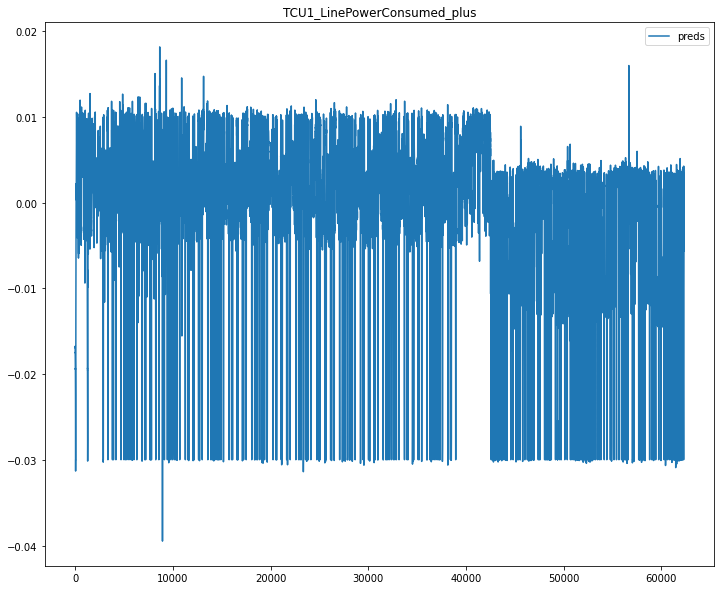

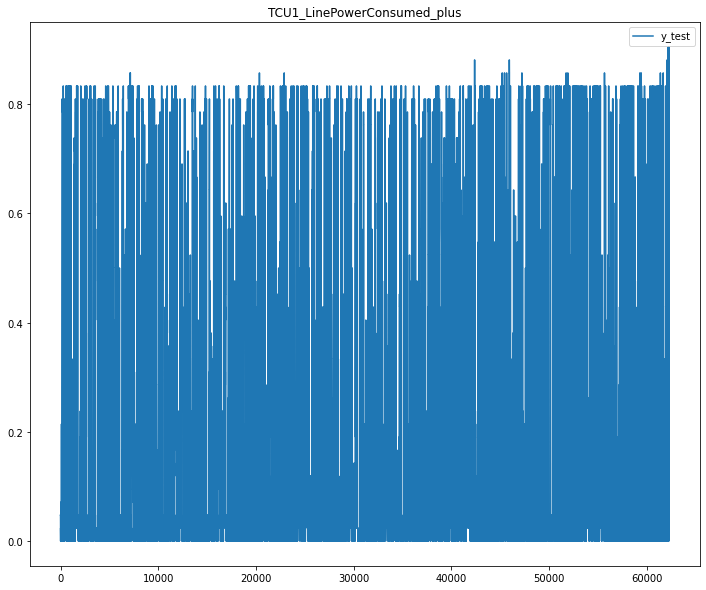

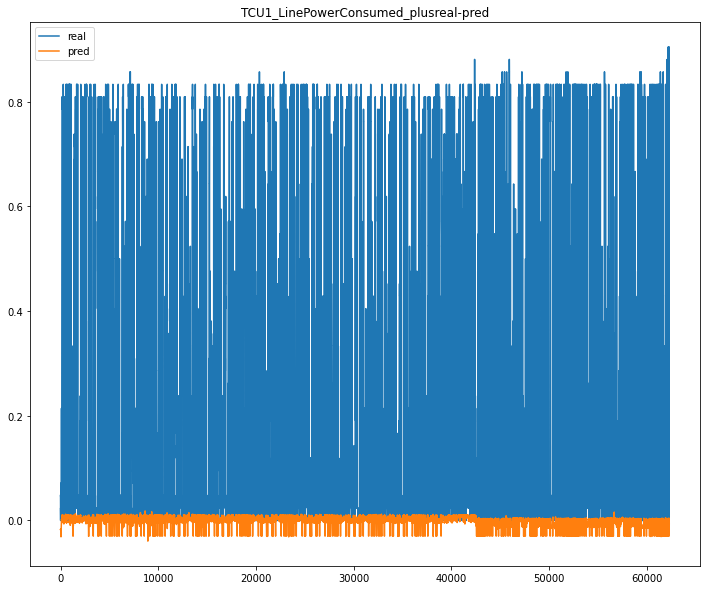

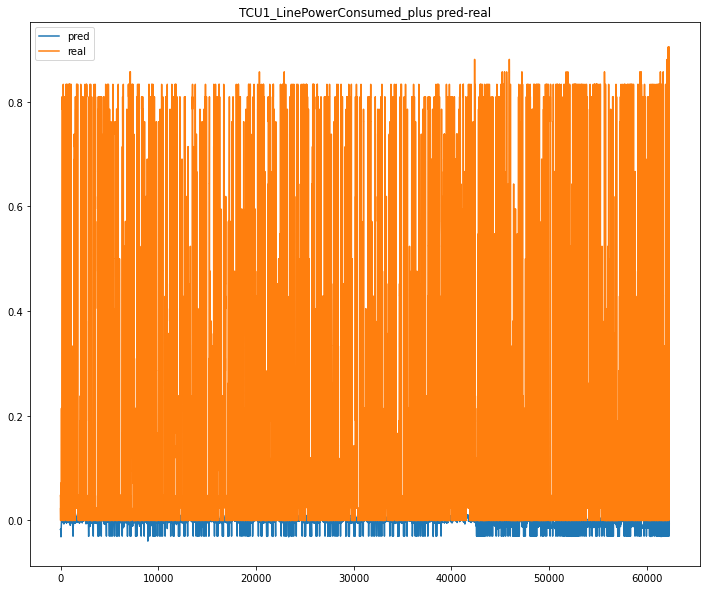

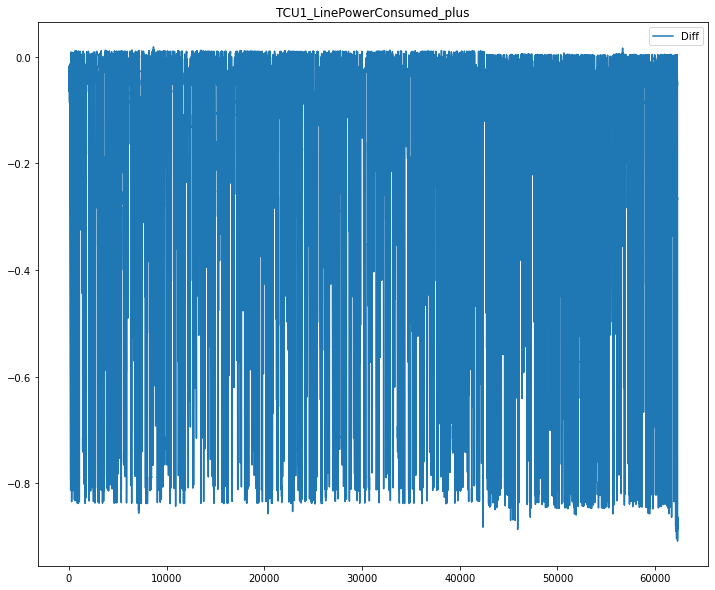

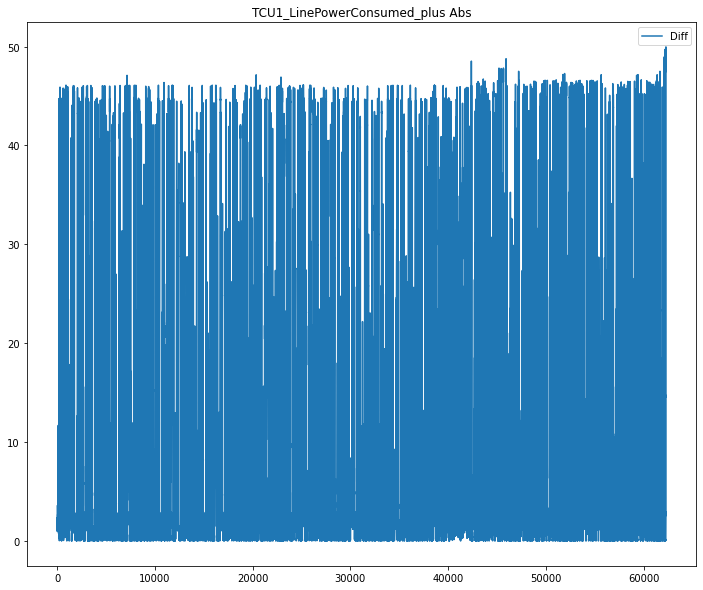

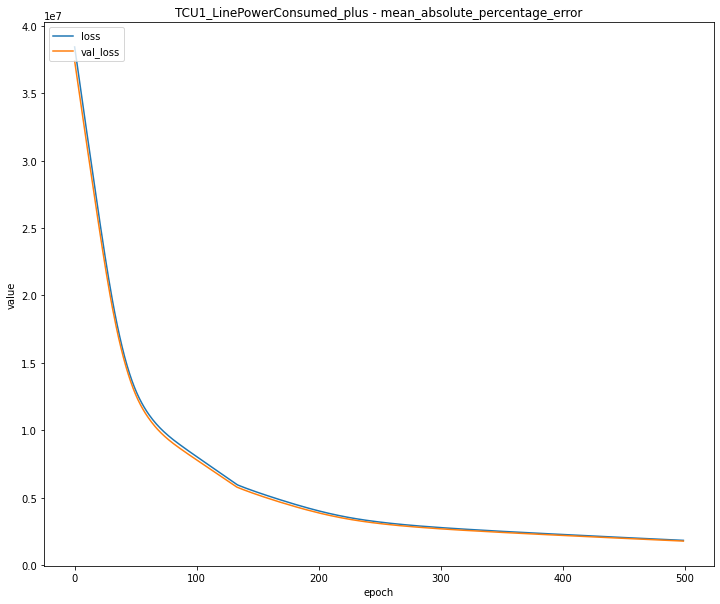

Fold : 1/3
Fold : 2/3
3/1440
Fold : 0/3
{'layers': (32, 16, 4), 'dropout': 0.2, 'batch_normalization': True, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'relu', 'func_regress': 'linear'}
 [Tue, 20 Apr 2021 23:27:06] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (32, 16, 4), 'dropout': 0.2, 'batch_normalization': True, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'relu', 'func_regress': 'linear'}
 [Tue, 20 Apr 2021 23:27:06] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:27:06] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [Tue, 20 Apr 2021 23:27:06] DEBUG [<ipython-

Epoch 64/500
1459/1459 - 1s - loss: 35626.0586 - val_loss: 141.0144
Epoch 65/500
1459/1459 - 1s - loss: 26368.9961 - val_loss: 110.0984
Epoch 66/500
1459/1459 - 1s - loss: 25759.8477 - val_loss: 345.4664
Epoch 67/500
1459/1459 - 1s - loss: 18729.8145 - val_loss: 110.7482
Epoch 68/500
1459/1459 - 1s - loss: 14050.0137 - val_loss: 785.3871
Epoch 69/500
1459/1459 - 1s - loss: 13248.7021 - val_loss: 1079.3684
Epoch 70/500
1459/1459 - 1s - loss: 22360.5332 - val_loss: 242.0336
Epoch 71/500
1459/1459 - 1s - loss: 14988.3223 - val_loss: 607.0264
Epoch 72/500
1459/1459 - 1s - loss: 15536.8975 - val_loss: 650.4611
Epoch 73/500
1459/1459 - 1s - loss: 19570.9746 - val_loss: 415.3895
Epoch 74/500
1459/1459 - 1s - loss: 9102.6875 - val_loss: 972.7755
Epoch 75/500
1459/1459 - 1s - loss: 21673.3223 - val_loss: 635.5731
Epoch 76/500
1459/1459 - 1s - loss: 16553.9082 - val_loss: 881.4575
Epoch 77/500
1459/1459 - 1s - loss: 4368.7397 - val_loss: 278.7862
Epoch 78/500
1459/1459 - 1s - loss: 15133.2158 - 

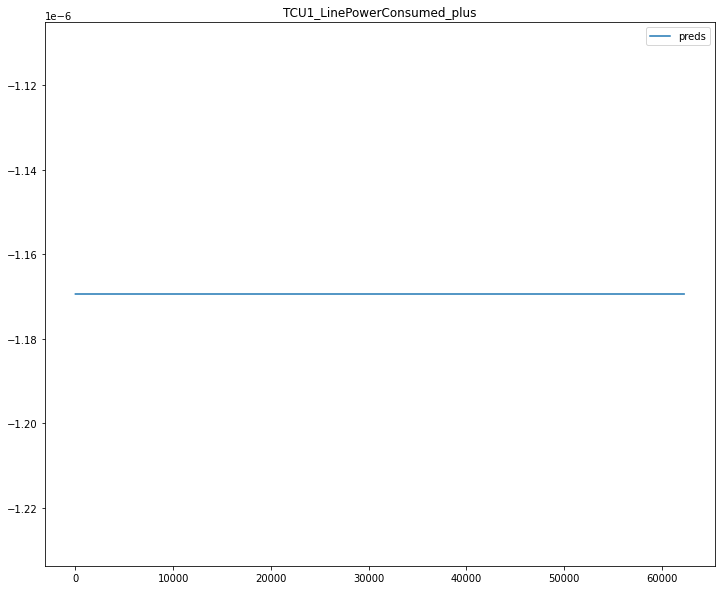

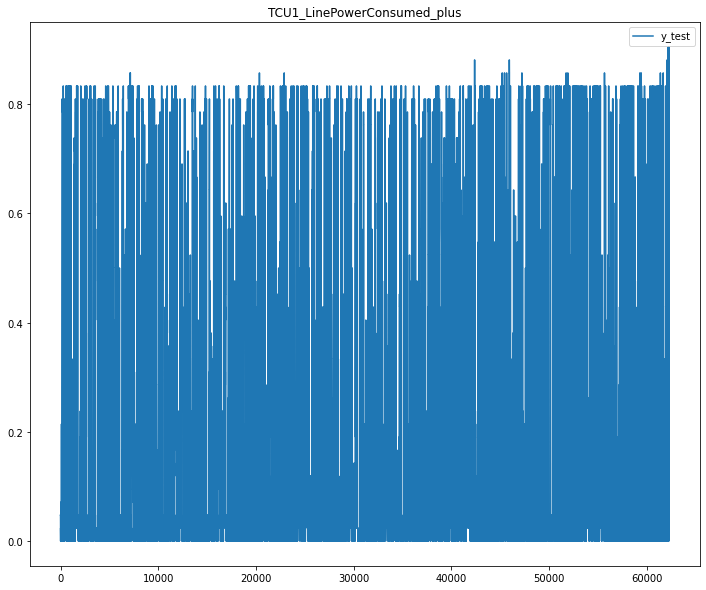

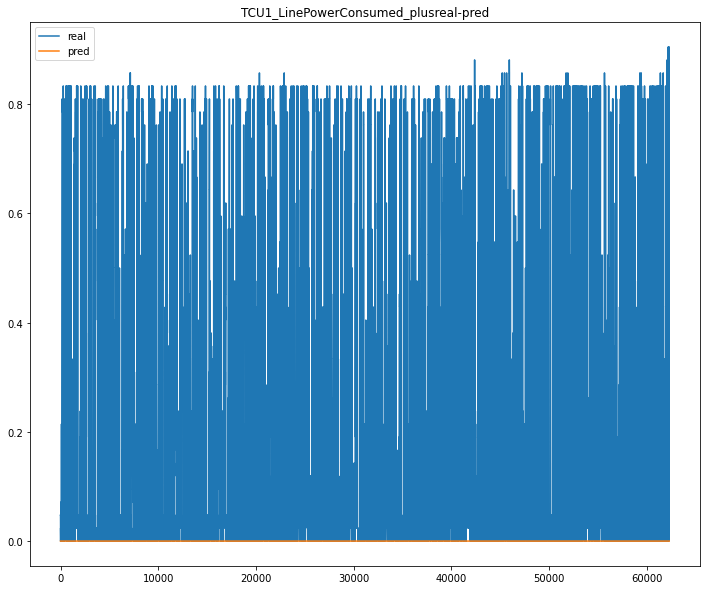

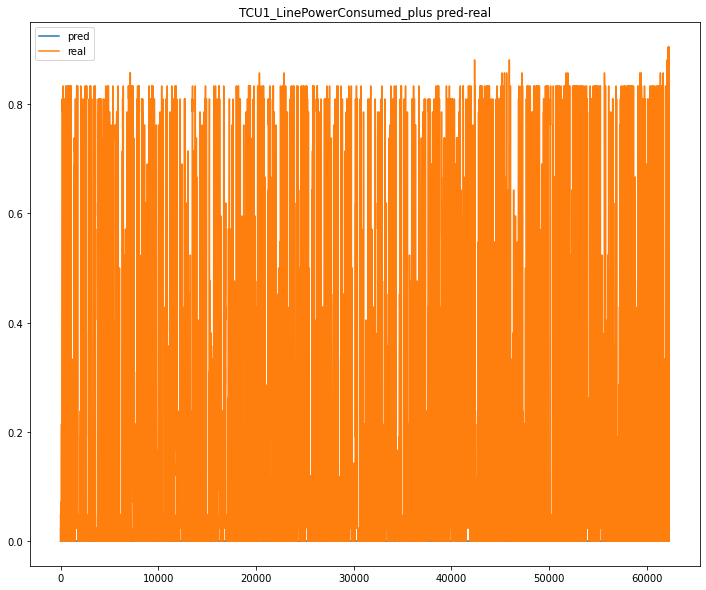

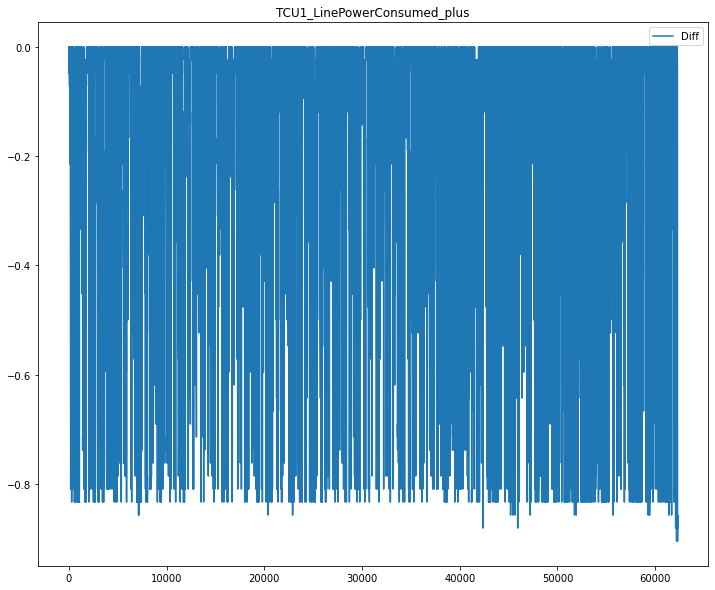

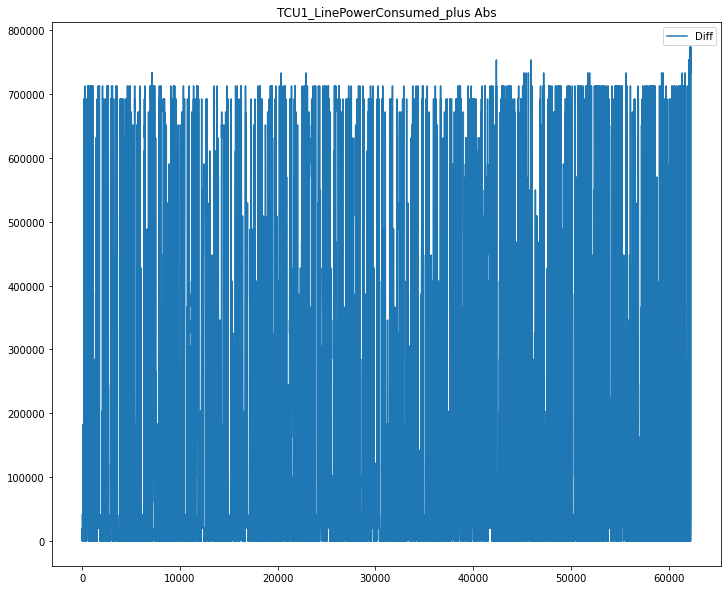

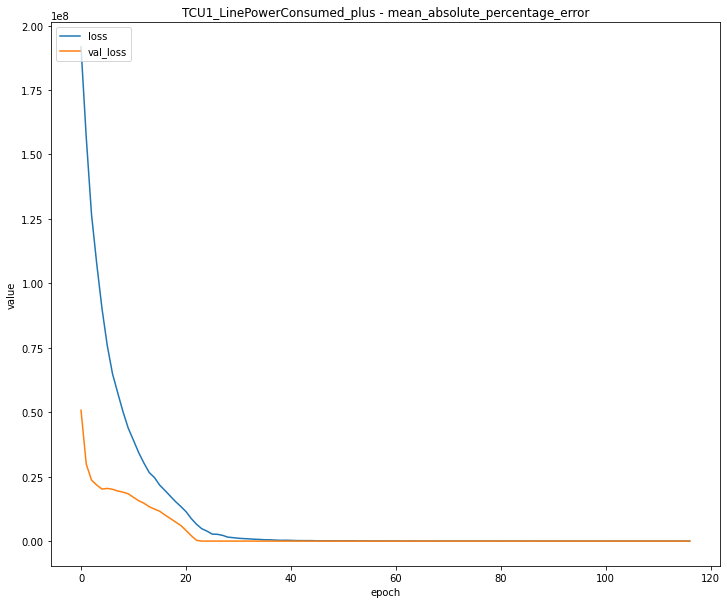

Fold : 1/3
Fold : 2/3
4/1440
Fold : 0/3
{'layers': (128, 64, 32, 16), 'dropout': 0.5, 'batch_normalization': False, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'relu', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:29:32] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (128, 64, 32, 16), 'dropout': 0.5, 'batch_normalization': False, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'relu', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:29:32] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:29:32] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 

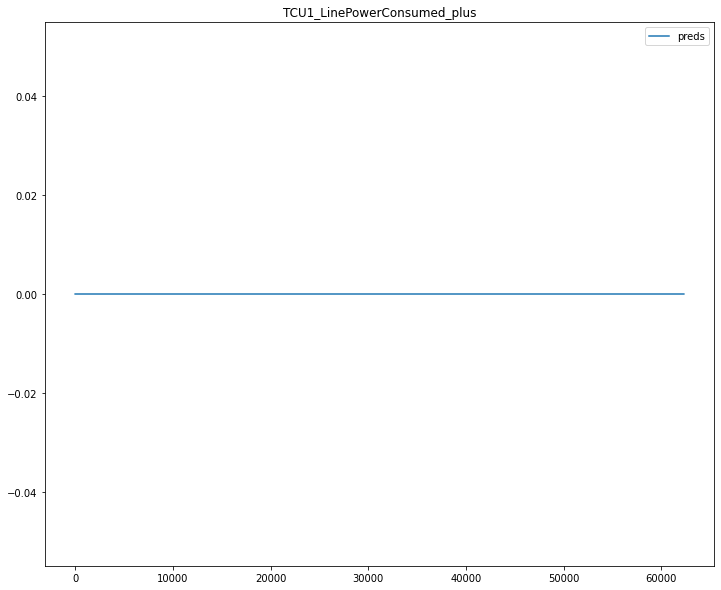

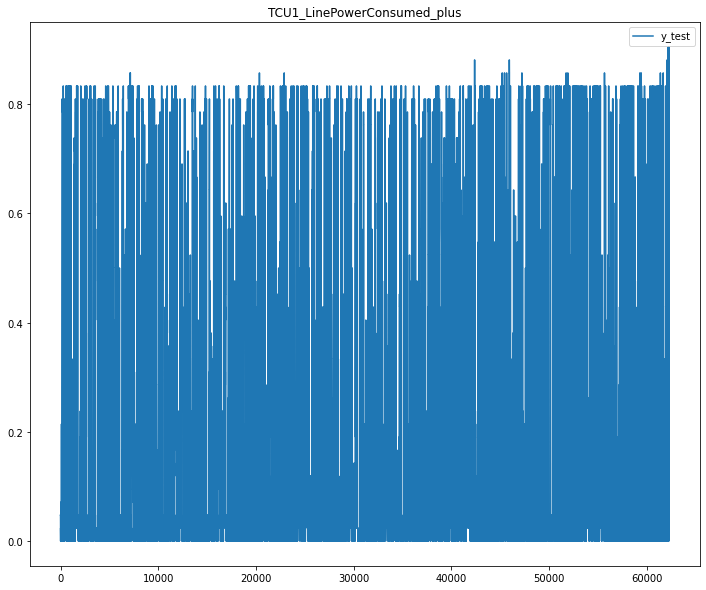

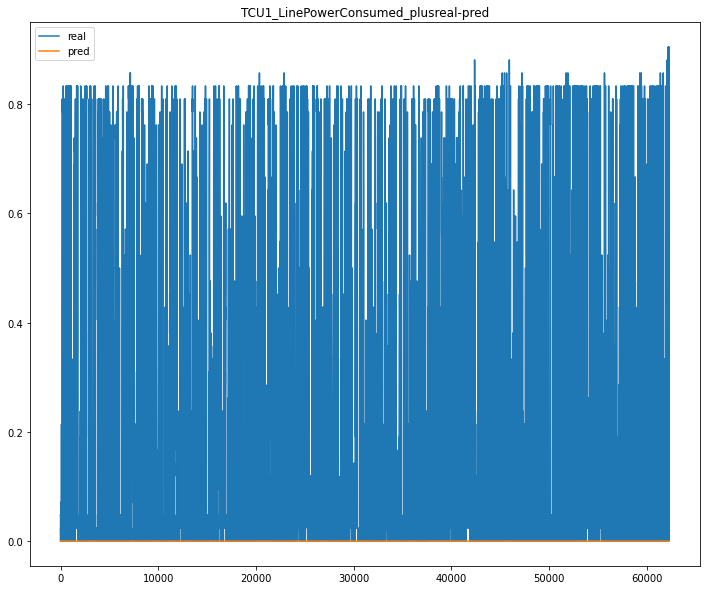

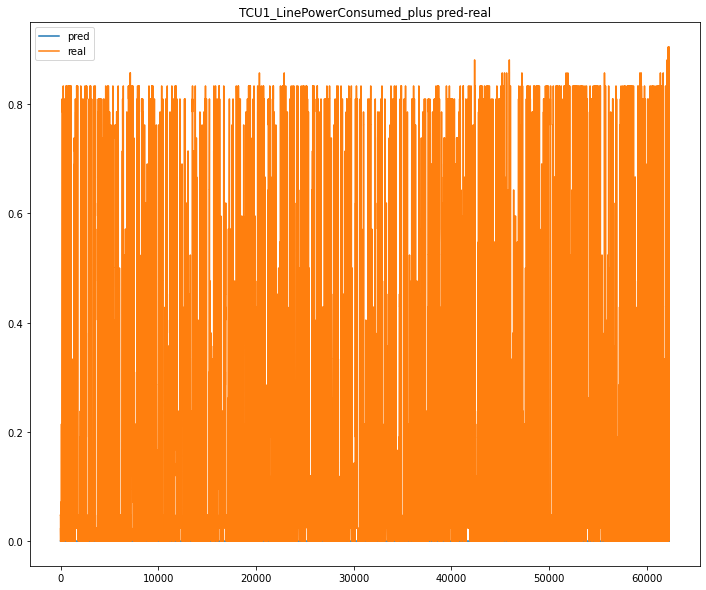

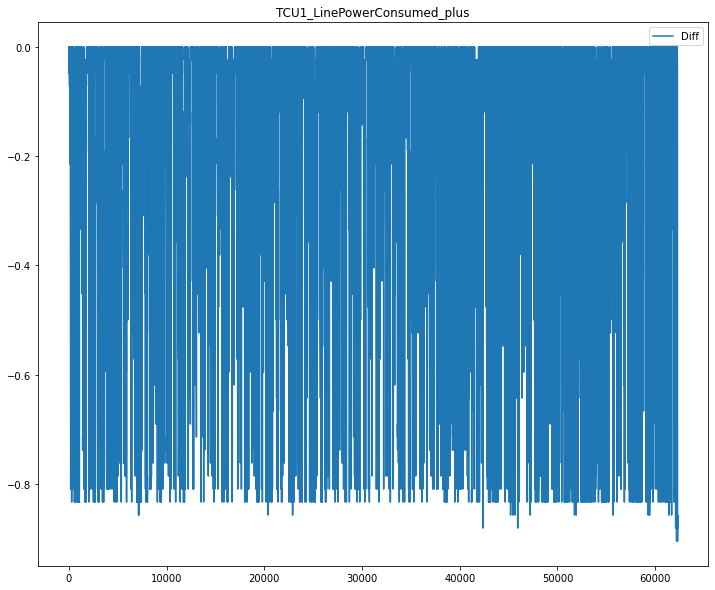

/home/maguelo/VirtualEnvs/cafcoding/lib/python3.8/site-packages/cafcoding-1.2.1-py3.8.egg/cafcoding/tools/visualization.py:98: RuntimeWarning: divide by zero encountered in true_divide
/home/maguelo/VirtualEnvs/cafcoding/lib/python3.8/site-packages/cafcoding-1.2.1-py3.8.egg/cafcoding/tools/visualization.py:98: RuntimeWarning: invalid value encountered in true_divide


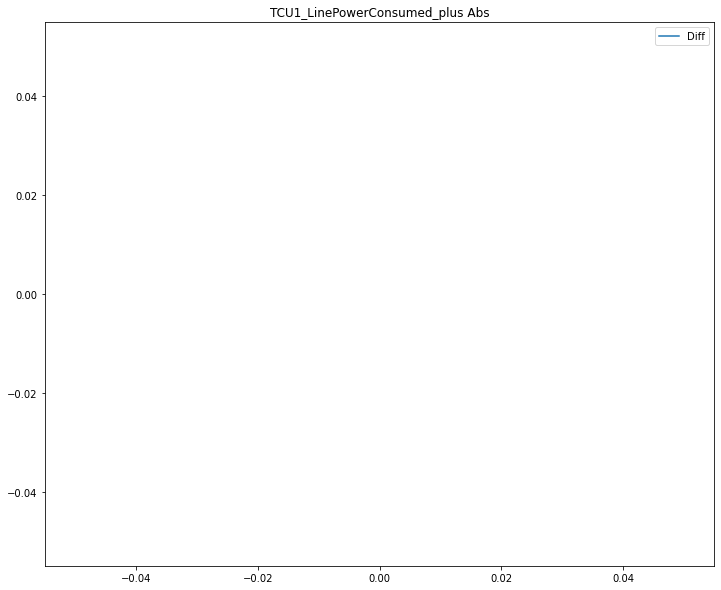

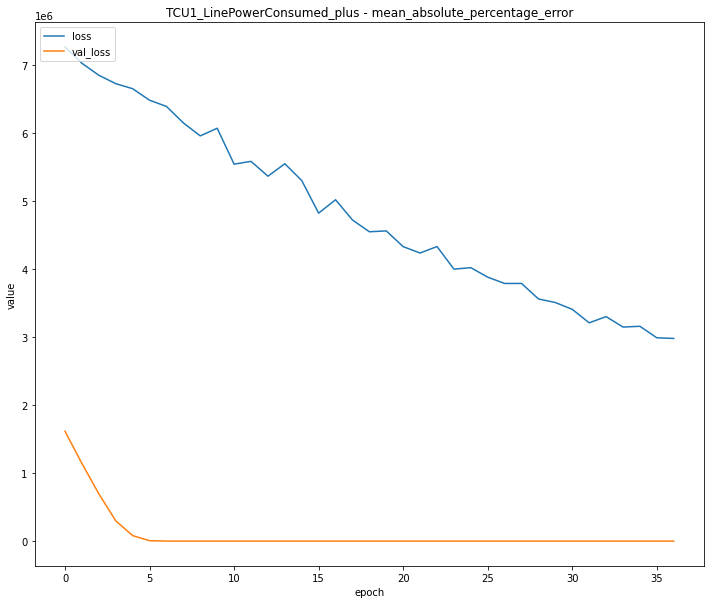

Fold : 1/3
Fold : 2/3
5/1440
Fold : 0/3
{'layers': (64, 32, 16), 'dropout': 0.2, 'batch_normalization': False, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'relu', 'func_regress': 'linear'}
 [Tue, 20 Apr 2021 23:30:20] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (64, 32, 16), 'dropout': 0.2, 'batch_normalization': False, 'lr': 1e-05, 'decay': 2e-08, 'batch_size': 32, 'func_act': 'relu', 'func_regress': 'linear'}
 [Tue, 20 Apr 2021 23:30:20] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:30:20] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [Tue, 20 Apr 2021 23:30:20] DEBUG [<ipyt

Epoch 70/500
1459/1459 - 1s - loss: 1172.7657 - val_loss: 412.8953
Epoch 71/500
1459/1459 - 1s - loss: 1031.3541 - val_loss: 260.7867
Epoch 72/500
1459/1459 - 1s - loss: 1204.0789 - val_loss: 1559.0972
Epoch 73/500
1459/1459 - 1s - loss: 1011.3100 - val_loss: 1040.3669
 [Tue, 20 Apr 2021 23:31:33] INFO [<ipython-input-34-f6a1df60d86f>.<module>:90] Best val loss : 168.4021759033203
 [Tue, 20 Apr 2021 23:31:33] INFO [<ipython-input-34-f6a1df60d86f>.<module>:93] Predicting TCU1_LinePowerConsumed_plus /home/maguelo/Workspace/cafcoding/notebook/models/model-TTCU1_LinePowerConsumed_plus-L64_32_16-D0.2-BNFalse-LR1e-05-DCY2e-08-BS32-BS32-I0.h5
TCU1_LinePowerConsumed_plus - avg: 0.19550352827569292, std: 0.28422289641188325
Absolut Percent Difference - mean: 1030317.42%, std: 1717884.75%


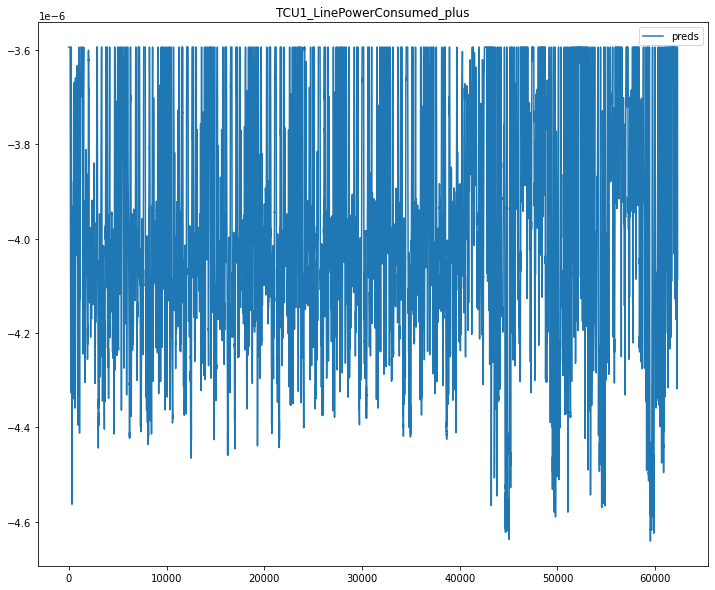

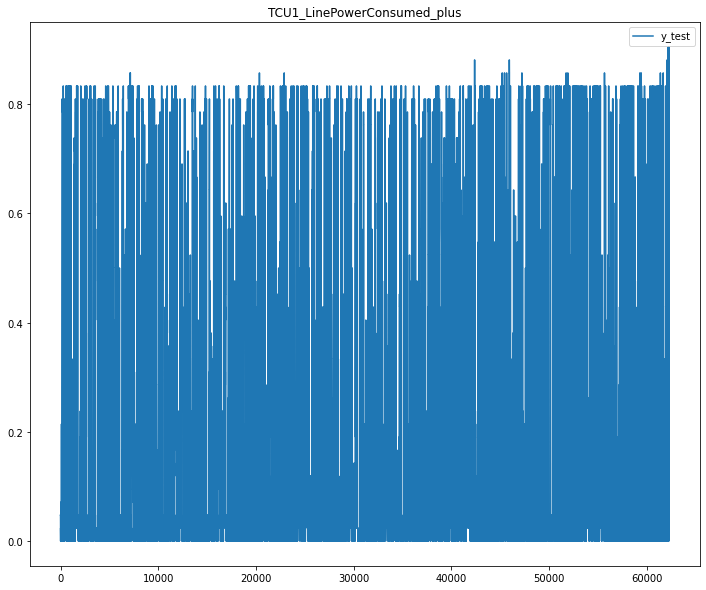

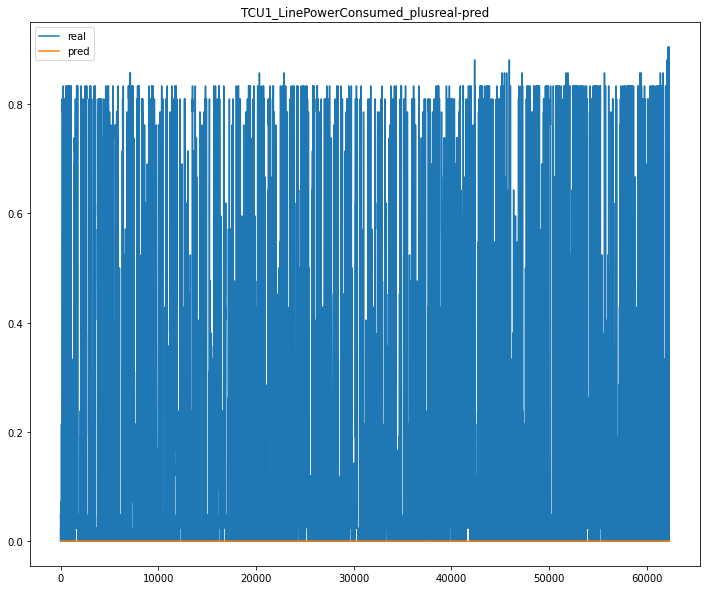

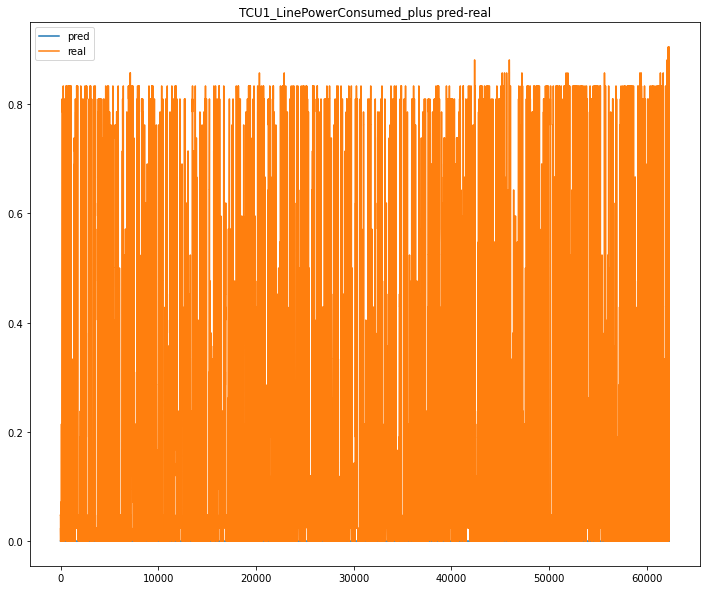

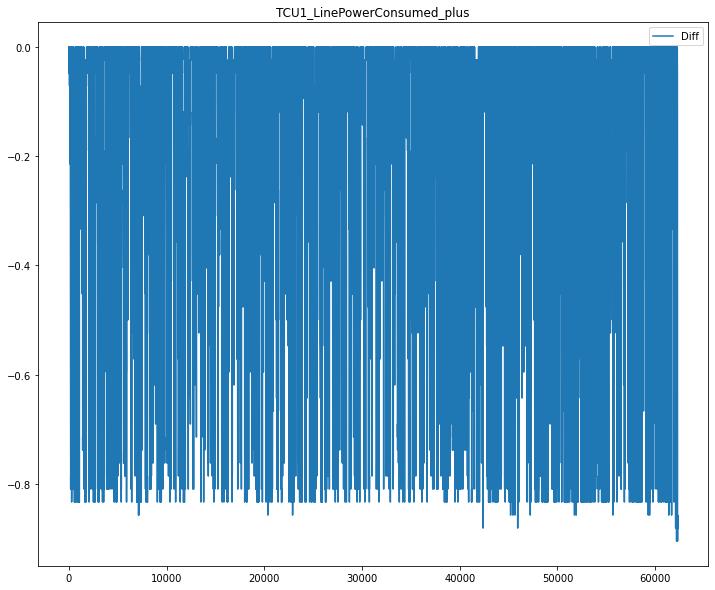

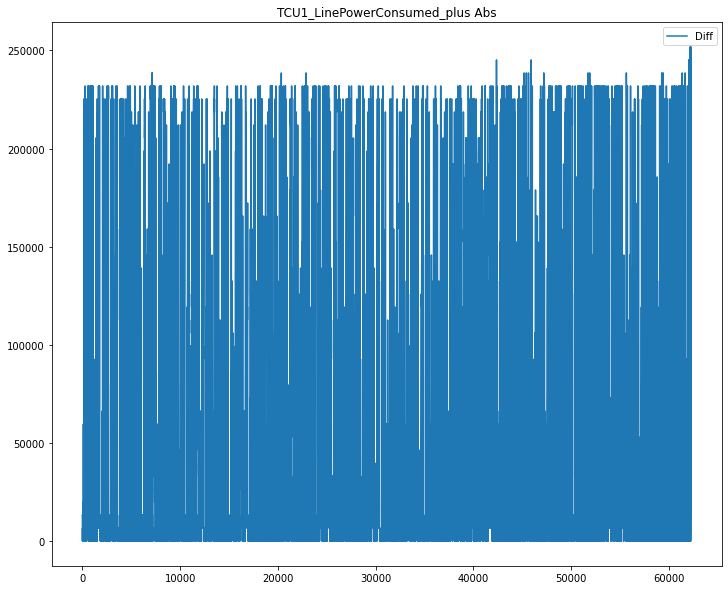

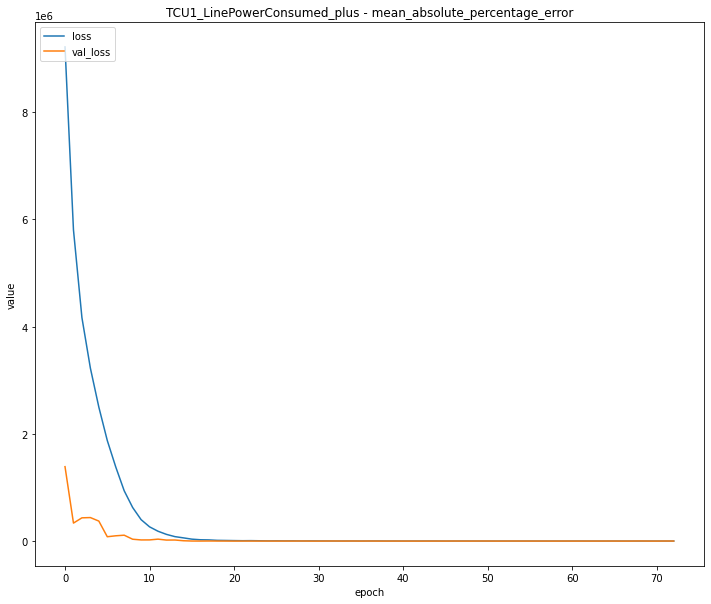

Fold : 1/3
Fold : 2/3
6/1440
Fold : 0/3
{'layers': (64, 32, 16), 'dropout': None, 'batch_normalization': True, 'lr': 1e-06, 'decay': 1.9999999999999997e-09, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:31:39] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (64, 32, 16), 'dropout': None, 'batch_normalization': True, 'lr': 1e-06, 'decay': 1.9999999999999997e-09, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:31:39] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:31:39] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [Tue

Epoch 63/500
1459/1459 - 1s - loss: 29904.9766 - val_loss: 25526.8086
Epoch 64/500
1459/1459 - 1s - loss: 17925.5645 - val_loss: 16409.7734
Epoch 65/500
1459/1459 - 1s - loss: 11452.5752 - val_loss: 6534.6479
Epoch 66/500
1459/1459 - 1s - loss: 4113.6309 - val_loss: 5692.0415
Epoch 67/500
1459/1459 - 1s - loss: 4710.1997 - val_loss: 7401.4565
Epoch 68/500
1459/1459 - 1s - loss: 4466.3145 - val_loss: 2818.4705
Epoch 69/500
1459/1459 - 1s - loss: 2522.8484 - val_loss: 1648.2506
Epoch 70/500
1459/1459 - 1s - loss: 5148.4146 - val_loss: 260.1505
Epoch 71/500
1459/1459 - 1s - loss: 4081.6121 - val_loss: 74.9347
Epoch 72/500
1459/1459 - 1s - loss: 1402.9390 - val_loss: 74.9296
Epoch 73/500
1459/1459 - 1s - loss: 1326.4199 - val_loss: 74.9327
Epoch 74/500
1459/1459 - 1s - loss: 1417.8641 - val_loss: 74.9357
Epoch 75/500
1459/1459 - 1s - loss: 335.0568 - val_loss: 74.9283
Epoch 76/500
1459/1459 - 1s - loss: 671.9320 - val_loss: 74.9333
Epoch 77/500
1459/1459 - 1s - loss: 3638.9512 - val_loss: 

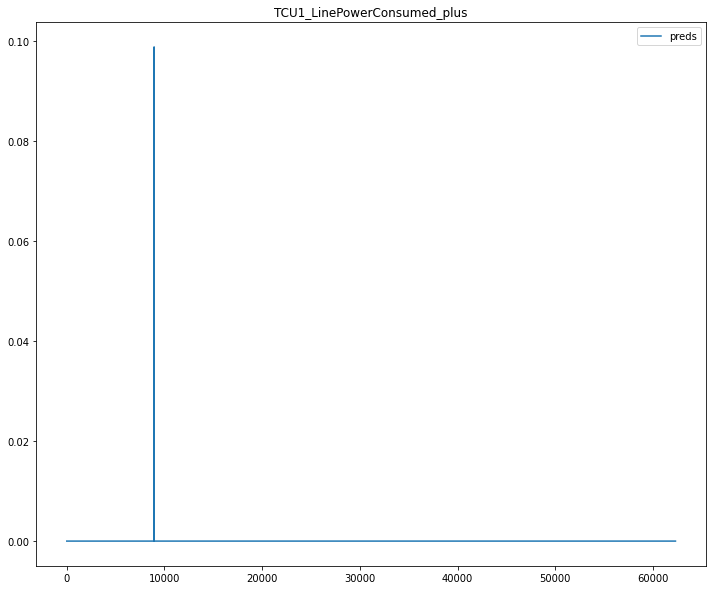

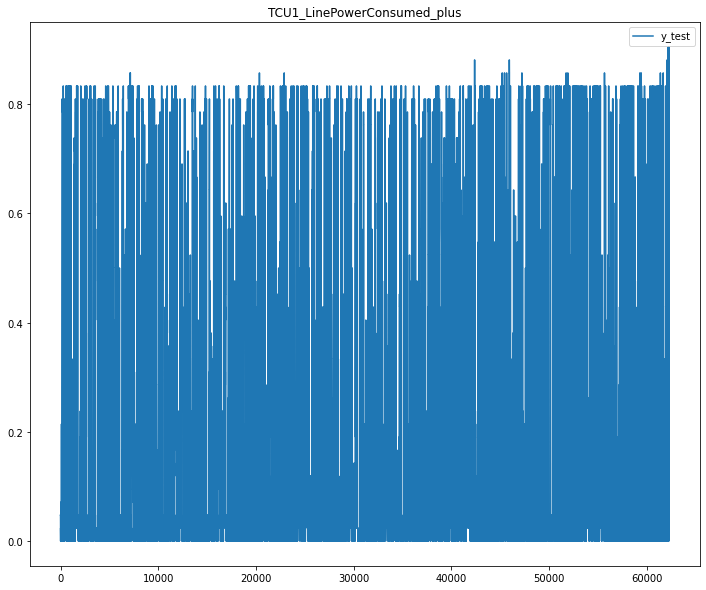

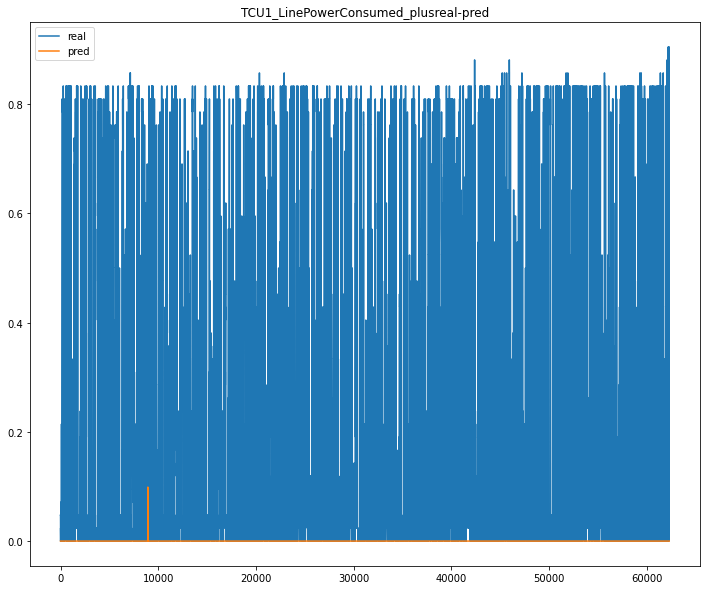

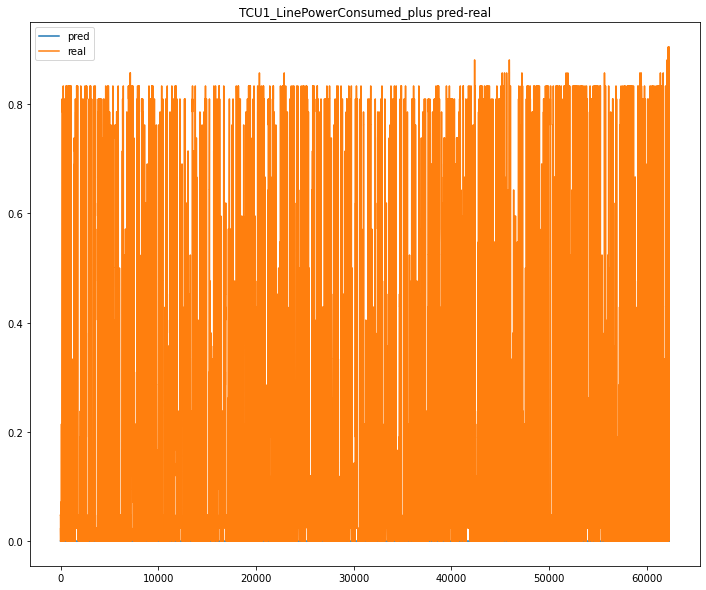

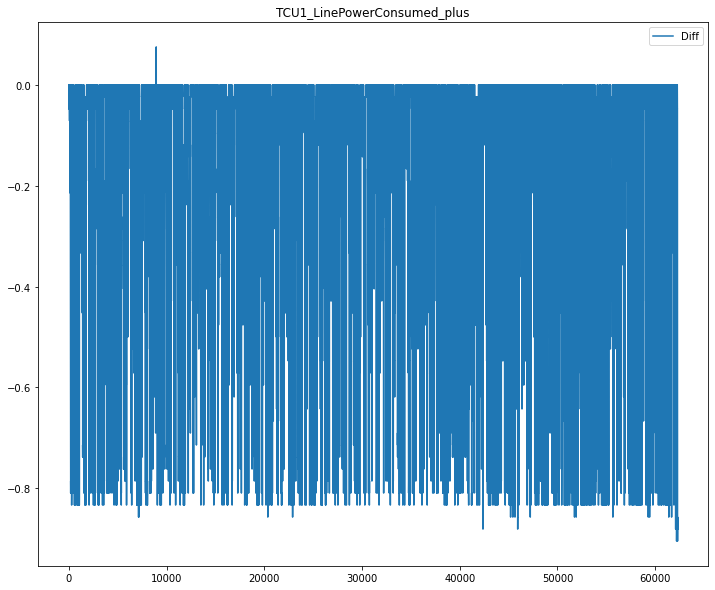

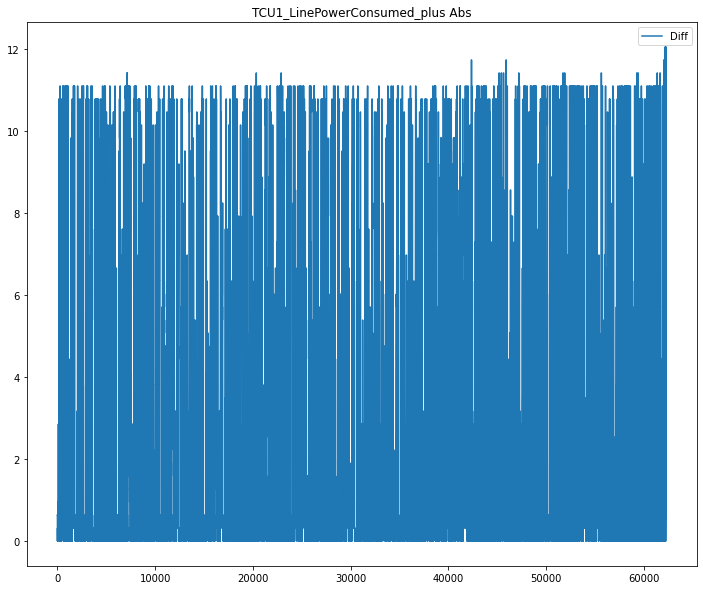

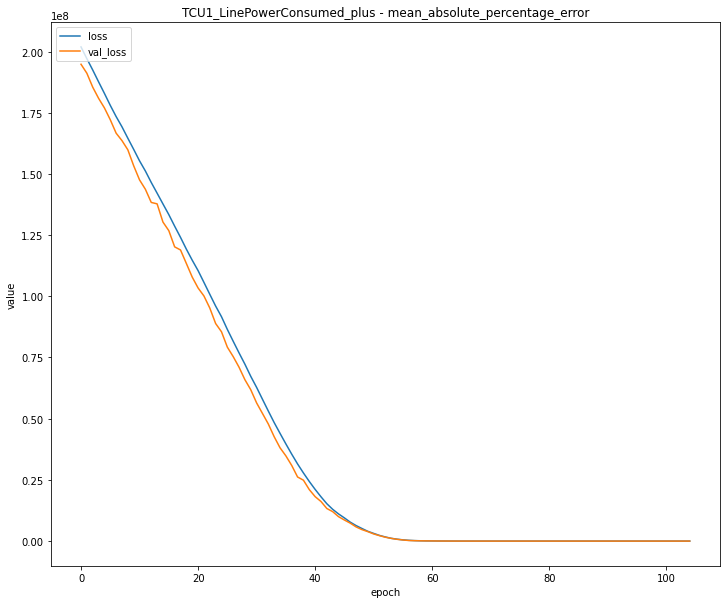

Fold : 1/3
Fold : 2/3
7/1440
Fold : 0/3
{'layers': (64, 32, 16), 'dropout': None, 'batch_normalization': False, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:33:53] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (64, 32, 16), 'dropout': None, 'batch_normalization': False, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'sigmoid', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:33:53] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:33:53] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Create model
 [T

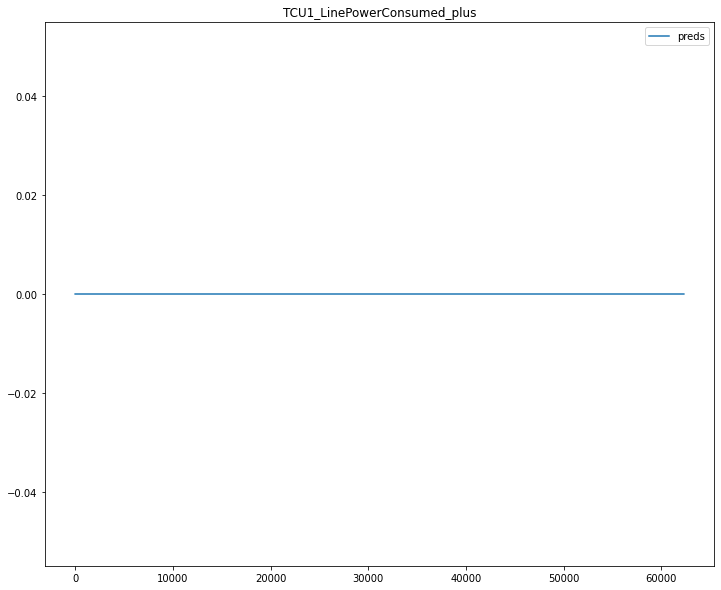

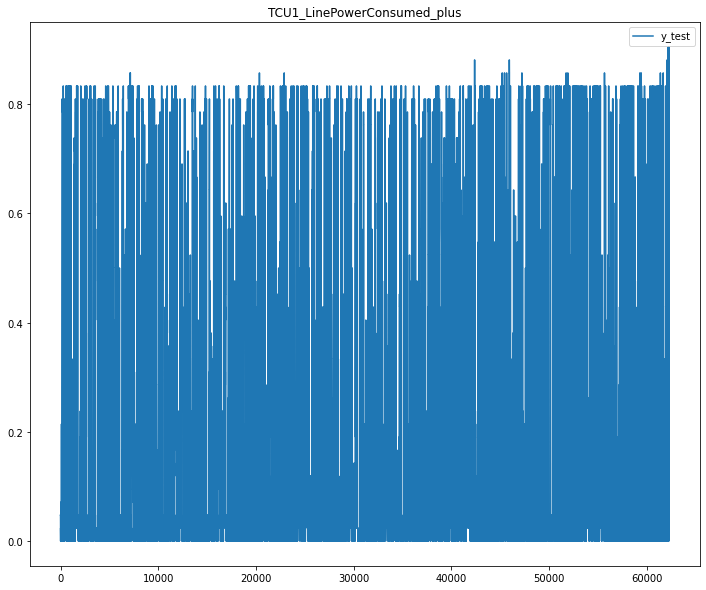

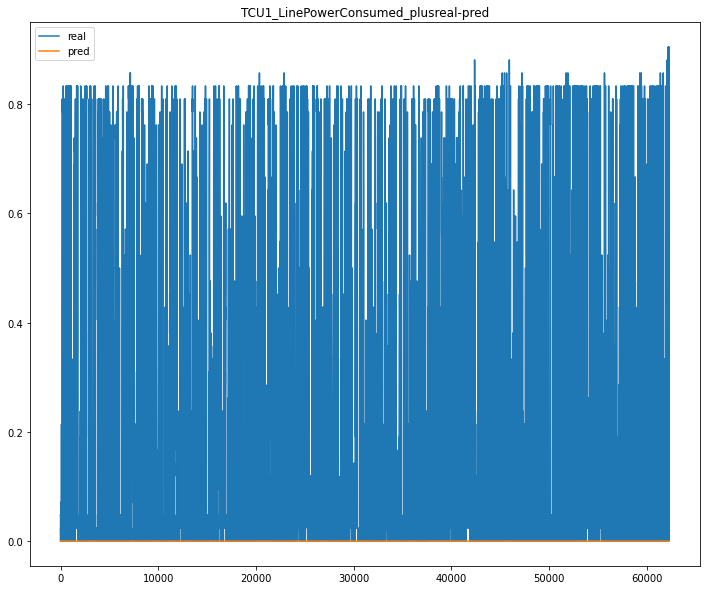

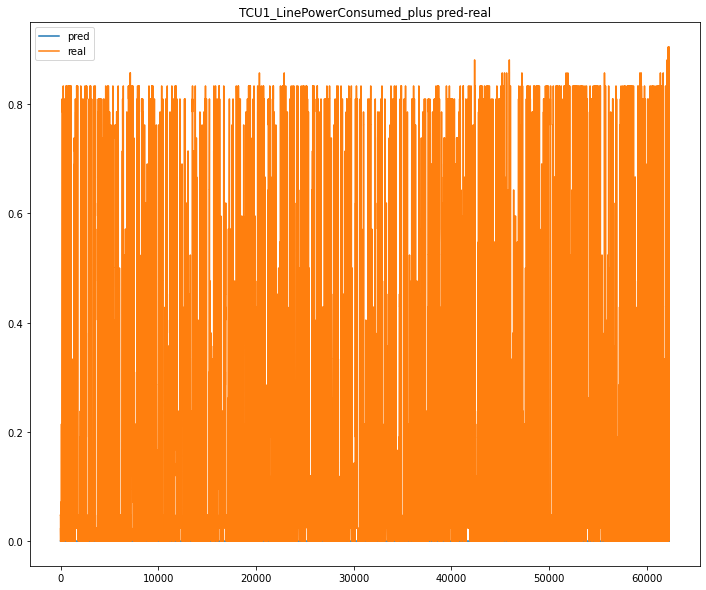

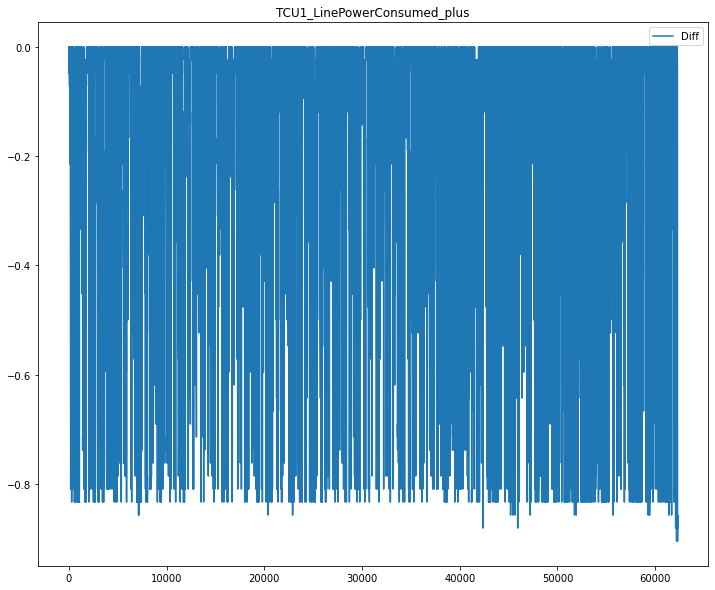

/home/maguelo/VirtualEnvs/cafcoding/lib/python3.8/site-packages/cafcoding-1.2.1-py3.8.egg/cafcoding/tools/visualization.py:98: RuntimeWarning: divide by zero encountered in true_divide
/home/maguelo/VirtualEnvs/cafcoding/lib/python3.8/site-packages/cafcoding-1.2.1-py3.8.egg/cafcoding/tools/visualization.py:98: RuntimeWarning: invalid value encountered in true_divide


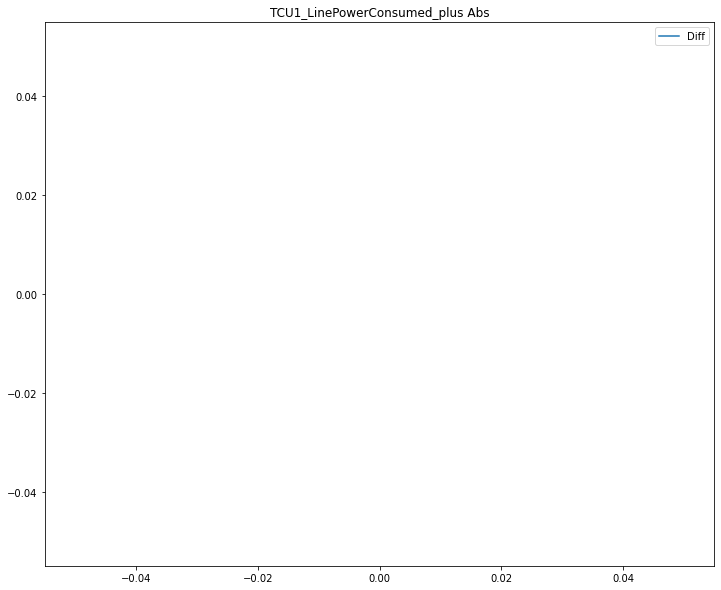

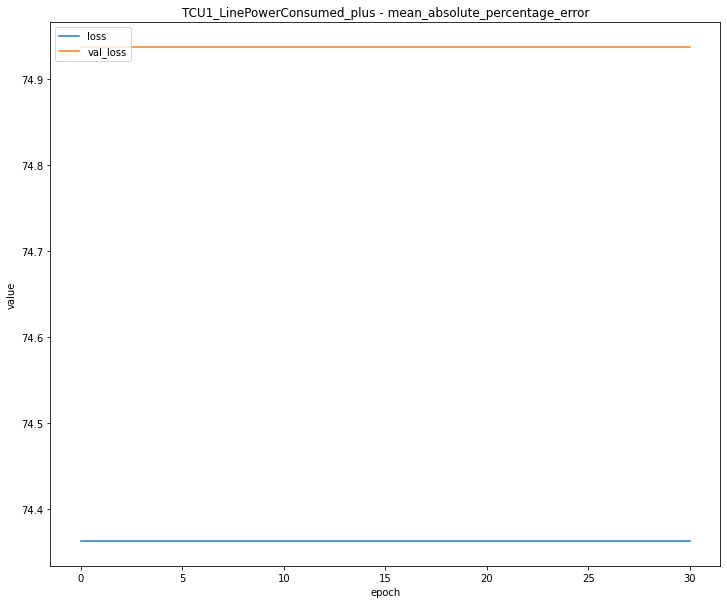

Fold : 1/3
Fold : 2/3
8/1440
Fold : 0/3
{'layers': (64, 64, 32, 32, 16, 16), 'dropout': 0.2, 'batch_normalization': True, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'tanh', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:34:26] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:79] Train model - params: {'layers': (64, 64, 32, 32, 16, 16), 'dropout': 0.2, 'batch_normalization': True, 'lr': 1e-07, 'decay': 1.9999999999999998e-10, 'batch_size': 32, 'func_act': 'tanh', 'func_regress': 'relu'}
 [Tue, 20 Apr 2021 23:34:26] DEBUG [<ipython-input-31-5966d9ce77c3>.train_model_dl:80] Train model - model_conf: {'early_stopping': {'monitor': 'val_loss', 'monitor_patience': 30, 'verbose': 0}, 'model_checkpoint': {'monitor': 'val_loss', 'save_best': True, 'verbose': 0}, 'model': {'loss_func': 'mean_absolute_percentage_error', 'verbose': 2}, 'n_kfold': 3, 'epochs': 500}
 [Tue, 20 Apr 2021 23:34:26] INFO [<ipython-input-31-5966d9ce77c3>.create_model_functional:49] Cr

Epoch 43/500
1459/1459 - 2s - loss: 58566040.0000 - val_loss: 40248420.0000
Epoch 44/500
1459/1459 - 2s - loss: 59702276.0000 - val_loss: 40911768.0000
Epoch 45/500
1459/1459 - 2s - loss: 57865868.0000 - val_loss: 42005244.0000
Epoch 46/500
1459/1459 - 2s - loss: 59372628.0000 - val_loss: 45682360.0000
Epoch 47/500
1459/1459 - 2s - loss: 59445604.0000 - val_loss: 42535072.0000
Epoch 48/500
1459/1459 - 2s - loss: 58443108.0000 - val_loss: 39785756.0000
Epoch 49/500
1459/1459 - 2s - loss: 58410892.0000 - val_loss: 39633132.0000
Epoch 50/500
1459/1459 - 2s - loss: 58453984.0000 - val_loss: 43516908.0000
Epoch 51/500
1459/1459 - 2s - loss: 57256836.0000 - val_loss: 41503364.0000
Epoch 52/500
1459/1459 - 2s - loss: 56214088.0000 - val_loss: 39834812.0000
Epoch 53/500
1459/1459 - 2s - loss: 57110020.0000 - val_loss: 37429376.0000
Epoch 54/500
1459/1459 - 2s - loss: 56743600.0000 - val_loss: 39084872.0000
Epoch 55/500
1459/1459 - 2s - loss: 56402192.0000 - val_loss: 42369700.0000
Epoch 56/500

1459/1459 - 2s - loss: 36183948.0000 - val_loss: 26941550.0000
Epoch 151/500
1459/1459 - 2s - loss: 36315668.0000 - val_loss: 27828624.0000
Epoch 152/500
1459/1459 - 2s - loss: 36298112.0000 - val_loss: 27932586.0000
Epoch 153/500
1459/1459 - 2s - loss: 36043268.0000 - val_loss: 25785128.0000
Epoch 154/500
1459/1459 - 2s - loss: 35562396.0000 - val_loss: 28908904.0000
Epoch 155/500
1459/1459 - 2s - loss: 35407700.0000 - val_loss: 28477768.0000
Epoch 156/500
1459/1459 - 2s - loss: 35379312.0000 - val_loss: 27370782.0000
Epoch 157/500
1459/1459 - 2s - loss: 35869088.0000 - val_loss: 25183504.0000
Epoch 158/500
1459/1459 - 2s - loss: 35341864.0000 - val_loss: 25892964.0000
Epoch 159/500
1459/1459 - 2s - loss: 34954232.0000 - val_loss: 27427238.0000
Epoch 160/500
1459/1459 - 2s - loss: 33997016.0000 - val_loss: 27691010.0000
Epoch 161/500
1459/1459 - 2s - loss: 35192980.0000 - val_loss: 26938208.0000
Epoch 162/500
1459/1459 - 2s - loss: 34079204.0000 - val_loss: 26433488.0000
Epoch 163/500

Epoch 257/500
1459/1459 - 2s - loss: 20210700.0000 - val_loss: 16455751.0000
Epoch 258/500
1459/1459 - 2s - loss: 20964962.0000 - val_loss: 16869700.0000
Epoch 259/500
1459/1459 - 2s - loss: 21120316.0000 - val_loss: 16450342.0000
Epoch 260/500
1459/1459 - 2s - loss: 19818540.0000 - val_loss: 17018958.0000
Epoch 261/500
1459/1459 - 2s - loss: 20421204.0000 - val_loss: 16270469.0000
Epoch 262/500
1459/1459 - 2s - loss: 19793920.0000 - val_loss: 17474578.0000
Epoch 263/500
1459/1459 - 2s - loss: 19889544.0000 - val_loss: 16773952.0000
Epoch 264/500
1459/1459 - 2s - loss: 19867038.0000 - val_loss: 16916290.0000
Epoch 265/500
1459/1459 - 2s - loss: 19350976.0000 - val_loss: 16159862.0000
Epoch 266/500
1459/1459 - 2s - loss: 19609516.0000 - val_loss: 17004222.0000
Epoch 267/500
1459/1459 - 2s - loss: 20033614.0000 - val_loss: 16963470.0000
Epoch 268/500
1459/1459 - 2s - loss: 18974306.0000 - val_loss: 15366451.0000
Epoch 269/500
1459/1459 - 2s - loss: 19245578.0000 - val_loss: 16934448.0000

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from sklearn.model_selection import TimeSeriesSplit, KFold
from keras.models import load_model
import random 

layers_list = [(8,4),(32,16,4),(64,32,16),(128,64,32,16),(64,64,32,32,16,16),] #(16, 16, 32, 32, 64, 64),(16, 32, 64, 128)] #(64,32,16,4), 
dropout_list = [None, 0.2, 0.5]
batch_normalization_list = [False, True]
lr_list =[1e-4,1e-5,1e-6,1e-7]#[1e-1, 1e-2,1e-3,1e-4]
batch_sizes_list = [32] #,64
N_KFOLD = 3
EPOCHS = 500
func_act_list = ['relu','tanh','sigmoid']
func_regress = ['relu','tanh','sigmoid', 'linear']



PLOT_PERCENT = 0.2 # 20%
#*0.1
model_conf ={'early_stopping':{'monitor': 'val_loss','monitor_patience': 30,#,EPOCHS*0.01,
                               'verbose':0},
             'model_checkpoint':{'monitor': 'val_loss', 'save_best':True, 'verbose':0},
             'model':{'loss_func':"mean_absolute_percentage_error",#"mean_squared_error",
                      'verbose':2,
                      #'metrics':['mse','mae'],
                      #'loss_func':"mean_absolute_percentage_error", 
                      #'metrics':[MeanAbsolutePercentageError()], 
                      #'metrics_name':['mean_absolute_percentage_error','val_mean_absolute_percentage_error'] # Para poder pintarlo
                     },
             'n_kfold': N_KFOLD,
             'epochs' : EPOCHS,
            }
#              'func_act':'relu',
#              'func_regress':'linear'}

    

params_options, params_option_size = utils.iterator_product(layers_list, dropout_list, batch_normalization_list, lr_list, batch_sizes_list, func_act_list,func_regress)

params_options = list(params_options)
random.shuffle(params_options)

#tscv = TimeSeriesSplit(n_splits=model_conf['n_kfold'])
tscv = KFold(n_splits=model_conf['n_kfold'],shuffle=True,random_state=42)


        
print(params_option_size)
result_list={}
for target in variables_objetivo[:1]:
    result_list[target]=[]
    print (f'{target}')
    iter_params_conf = 0
    for layers, dropout, batch_normalization, lr, batch_size, func_act, func_regress in list(params_options):
        print (f'{iter_params_conf}/{params_option_size}')
        
        iter_params_conf+=1
        
        params = create_params_dict(layers, dropout, batch_normalization, lr, batch_size, model_conf['epochs'],func_act, func_regress)
  
        
        
        ignore_columns = list(set(conf_dict['ignore_columns'] + variables_objetivo +discard_columns + variables_objetivo_current)) 
        #conf_dict['lasso_candidates'][target] +  conf_dict['columns_2_drop'][target]['corr_drops'] #conf_dict['lasso_candidates']
        
        for kfold, (train_index, val_index) in enumerate(tscv.split(df['train'][:70000])):
            print (f'Fold : {kfold}/{N_KFOLD}')
            # if kfold > 0:
            #     continue
                
#             kfold=0
            print(params)
            train_info_dict = create_train_info_dict(store_model_path, params,target, kfold, model_conf)


#             X_train, y_train,features = models.prepare_dataset(df['train'], ignore_columns,target)
#             X_val, y_val,_ = models.prepare_dataset(df['val'][:int(len(df['val'])/10)], ignore_columns,target)

            X_train, y_train,features = models.prepare_dataset(df['train'], ignore_columns,target, kfold=train_index)
            X_val, y_val,_ = models.prepare_dataset(df['train'], ignore_columns,target, kfold=val_index)
            X_test, y_test,_ = models.prepare_dataset(df['test'], ignore_columns,target)


            history, best_val_loss,model = train_model_dl((X_train, y_train),
                                                               (X_val, y_val), 
                                                               params, 
                                                               model_conf, 
                                                               filename=train_info_dict['model'])
            logger.info(f'Best val loss : {best_val_loss}')


            logger.info(f'Predicting {target} {train_info_dict["model"]}')
            #model = load_model(train_info_dict['model'])
            
            preds = model.predict(np.array(X_test))
            #(X_test)
    #             print(X_test)
    #             print (preds.flatten())

            quick_analysis(preds, y_test)
            create_plots(history, preds, y_test, target,train_info_dict,model_conf ,plot_percent=PLOT_PERCENT)

            train_info_dict['etl_version']=etl_step.ETL_VERSION
            train_info_dict['features']=features
            train_info_dict['val_loss']=best_val_loss
            train_info_dict['history']=history.history

            with open(train_info_dict['train_info'].format(best_val_loss),'wb') as f:
                pickle.dump( train_info_dict,f)
            result_list[target].append((best_val_loss,train_info_dict['train_info'].format(best_val_loss)))



In [ ]:
features=list(features)
features.sort()
print (features)
print (X_test)
print (y_test)

In [ ]:
np.mean(y_train)

In [ ]:
# ignore_columns = list(set(conf_dict['ignore_columns'] + variables_objetivo +discard_columns + variables_objetivo_current)) 
ignore_columns.sort()
print ("\n".join(ignore_columns))

In [ ]:
preds.flatten()
# for col in df['train'].columns:
#     print (df['train'][col].describe().T)
# # visualization.plot_two_series(y_train, y_test, "serie1", "serie2")
# # preds_train = model.predict(X_train)
# # visualization.plot_two_series(preds_train.flatten(), y_train, "serie1", "serie2")
# # visualization.plot_one_series(y_train,"serie2")
# # visualization.plot_one_series(preds_train.flatten(), "serie1")

In [ ]:
result_filename = 'results_'+etl_step.ETL_VERSION+'_'+utils.get_timestamp()+'.pickle'

with open(result_filename,'wb') as f:
    pickle.dump( result_list,f)